#CPK: KPI 3

In [ ]:
import pandas as pd

telemetria= pd.read_excel("/content/Telemetría.xlsx", sheet_name = "Report")

#borrar duplicados
telemetria = telemetria.drop_duplicates()

telemetria['Mes'] = telemetria['Fecha de inicio del periodo'].dt.to_period('M')
distancia_por_mes = telemetria.groupby('Mes')['Distancia'].sum()

tablero= pd.read_excel("/content/Tablero_PL_2024-09_2025-09_v2.xlsx", sheet_name = "Long PL Meses" )

#seleccionar solo los datos de Rubro == "2.Costo"
tablero = tablero[tablero["Rubro"] == "2. Costo"]

#renombrar Date a Mes
tablero = tablero.rename(columns={"Date": "Mes"})

#aplicar formato Period[M] a la columna de Mes
tablero['Mes'] = pd.to_datetime(tablero['Mes']).dt.to_period('M')

#Establecer la columna de Date de tablero como índice
tablero.set_index("Mes", inplace=True)
#seleccionar solo la columna de Rubro y Real
tablero = tablero[["Rubro", "Real"]]

#hacer merge de tablero y telemetria por fecha
tablero = tablero.merge(distancia_por_mes, left_index=True, right_index=True, how="left")

#agregar una nueva columna que divida Real entre Distancia
tablero["CPK"] = tablero["Real"] / tablero["Distancia"]

#eliminar nulos en CPK
tablero.dropna(inplace=True)

#CPK
CPK_promedio = tablero["CPK"].mean()

#Costo promedio combustible: KPI 2

In [ ]:
import pandas as pd
#CÁLCULO DE COMBUSTIBLE (Rendimiento y Precio) ---
df_fuel = pd.read_excel('/content/Enero-febrero 2025 Combustible.xlsx')

cols_num = ['Precio Unitario Merc', 'Recorrido', 'Cantidad Mercancía']
for col in cols_num:
    df_fuel[col] = df_fuel[col].astype(str).str.replace('$', '').str.replace(',', '')
    df_fuel[col] = pd.to_numeric(df_fuel[col], errors='coerce')

#filtar a region Merida CG
df_fuel = df_fuel[df_fuel['Región'] == 'MERIDA CG'].copy()

#filtro para que el Precio Unitario Merc no incluya 0
df_fuel = df_fuel[df_fuel['Precio Unitario Merc'] > 0].copy()

# Calcular Precio Promedio y Rendimiento de la Flota
precio_diesel_promedio = df_fuel['Precio Unitario Merc'].mean()
precio_diesel_promedio

np.float64(25.83771929824561)

#CLÚSTER

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats


#DF
listado_viajes = pd.read_excel("/content/Reporte Listado Viajes Ene-Oct_25.xlsx")

listado_viajes['Fecha Vencimiento'] = pd.to_datetime(listado_viajes['Fecha Vencimiento'], errors='coerce')
listado_viajes['Fecha Salida'] = pd.to_datetime(listado_viajes['Fecha Salida'], errors='coerce')
listado_viajes['Fecha Llegada'] = pd.to_datetime(listado_viajes['Fecha Llegada'], errors='coerce')

listado_viajes = listado_viajes.drop(columns=['Documentos', 'UUID CP'])
listado_viajes = listado_viajes.dropna(subset=['Fecha Salida'])
listado_viajes = listado_viajes.dropna(subset=['Estatus de Viaje'])
listado_viajes = listado_viajes.dropna(subset=['Nro Ope', 'Operador', 'Tractocamión'])
listado_viajes = listado_viajes.drop(columns=['Peso Descarga Kgs'])
listado_viajes = listado_viajes.drop_duplicates(keep='first')
mask = (listado_viajes['Fecha Llegada'].dt.year <= 2025) & (listado_viajes['Fecha Salida'].dt.year <= 2025) & (listado_viajes['Fecha Salida'].dt.year >= 2024)
# Aplicar la máscara para filtrar los datos
df = listado_viajes[mask]


# 1. Calcular Volumen Total por Ruta
ruta_volumen = df.groupby('Ruta')['Viaje'].count().reset_index(name='Total_Viajes')

# 2. Calcular cuántos viajes tiene el cliente MÁS GRANDE de cada ruta
# Agrupamos por Ruta y Cliente, contamos viajes, ordenamos y tomamos el primero (el mayor) de cada ruta
ruta_cliente = df.groupby(['Ruta', 'Nombre Cliente'])['Viaje'].count().reset_index()
ruta_max_cliente = ruta_cliente.sort_values(['Ruta', 'Viaje'], ascending=[True, False]) \
                               .groupby('Ruta').first().reset_index()

# 3. Unir y calcular el porcentaje de dependencia (Concentración)
data_cluster = pd.merge(ruta_volumen, ruta_max_cliente[['Ruta', 'Viaje']], on='Ruta')
data_cluster.rename(columns={'Viaje': 'Viajes_Cliente_Top'}, inplace=True)

# Variable clave: ¿Qué % de la ruta controla el cliente #1?
data_cluster['Porcentaje_Dependencia'] = data_cluster['Viajes_Cliente_Top'] / data_cluster['Total_Viajes']

# Seleccionamos solo las variables numéricas para el modelo
X = data_cluster[['Total_Viajes', 'Porcentaje_Dependencia']]

# Estandarizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenar K-Means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Asignar los clusters a nuestros datos originales
data_cluster['Cluster_Riesgo'] = labels

#lista de rutas clasificadas en Cluster_Riesgo 2
cluster_2 = data_cluster[data_cluster['Cluster_Riesgo'] == 2]
cluster_1 = data_cluster[data_cluster['Cluster_Riesgo'] == 1]
cluster_0 = data_cluster[data_cluster['Cluster_Riesgo'] == 0]
cluster_2 = cluster_2["Ruta"].tolist() #crítico
cluster_1 = cluster_1["Ruta"].tolist() #moderado
cluster_0 = cluster_0["Ruta"].tolist() #alto

#OBTENER NIVEL DE SERVICIO: KPI 4

In [ ]:
mapa_clusters = {}

for r in cluster_2: mapa_clusters[r] = "Cluster 2 (CRÍTICO)"
for r in cluster_1: mapa_clusters[r] = "Cluster 1 (MODERADO)"
for r in cluster_0: mapa_clusters[r] = "Cluster 0 (ALTO)"

METAS_POR_CLUSTER = {
    "Cluster 2 (CRÍTICO)":      95,
    "Cluster 1 (MODERADO)":     90,
    "Cluster 0 (ALTO)": 93,
    "Sin Clasificar / Otro":    90.0
}

def get_service_level_function(route_name):

    cluster_name = mapa_clusters.get(route_name, "Sin Clasificar / Otro")

    service_level = METAS_POR_CLUSTER.get(cluster_name, 98.0)

    return service_level


get_service_level_function('BB CIUDAD DEL CARMEN/BB PACABTUN')

95

#$ MOV EN VACIO

In [ ]:
#lista de rutas
ruta = "BB PACABTUN/BB CIUDAD DEL CARMEN"

rutas_raw = [
    'BB PACABTUN/BB CIUDAD DEL CARMEN', 'BB CIUDAD DEL CARMEN/BB PACABTUN',
    'BB PACABTUN/BB CAMPECHE OTE', 'BB CAMPECHE OTE/BB PACABTUN',
    'BB PACABTUN/BB PLAYA DEL CARMEN', 'BB PLAYA DEL CARMEN/BB PACABTUN',
    'BB PACABTUN/BB XPUJIL', 'BB XPUJIL/BB PACABTUN',
    'CEDIS WALMART CHALCO/BODEGA AURRERA TEZIUTLAN',
    'WM CEDIS MID TEYA/ SMURFFIT KAPPA', 'WM CEDIS CHALCO/SAMS CLUB CUAUTLA',
    'WM CEDIS CHALCO/CHIMALHUACAN PEÑON', 'WM CEDIS CHALCO/SAMS CLUB TEHUACAN',
    'SAMS CLUB TEHUACAN/WM CEDIS CHALCO', 'WM CEDIS CHALCO/SAMS CLUB EL MOLINITO',
    'SAMS CLUB EL MOLINITO/COMERCIALIZADORA NAREMO', 'SAMS CLUB EL MOLINITO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA SOR JUANA', 'BODEGA SOR JUANA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA CUAUTLA 2', 'BODEGA CUAUTLA 2/WM CEDIS CHALCO',
    'WM CD JARDIN/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA MARTINEZ DE LA TORRE',
    'BODEGA MARTINEZ DE LA TORRE/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA ANGELES IZTAPALAPA',
    'BODEGA ANGELES IZTAPALAPA/WM CEDIS CHALCO', 'SAMS CLUB CUERNAVACA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM DOMINGO DIEZ', 'WM DOMINGO DIEZ/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA VALLE DE CHALCO', 'BODEGA VALLE DE CHALCO/WM CEDIS CHALCO',
    'WM BODEGA REMOTA CHALCO/WM CEDIS CHALCO', 'COMERCIALIZADORA EL ORO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM CHALCO 2000', 'WM CHALCO 2000/WM CEDIS CHALCO',
    'WM CEDIS VILLAHERMOSA SECOS/PENSION SALINAS CRUZ', 'PENSION SALINAS CRUZ/WM CEDIS VILLAHERMOSA SECOS',
    'PENSION SALINAS CRUZ/BODEGA AURRERA JUCHITAN', 'BODEGA AURRERA JUCHITAN/PENSION SALINAS CRUZ',
    'WM CEDIS CHALCO/WM HIPERPLAZA TEXCOCO', 'WM CEDIS CHALCO/BODEGA GLORIETA APIZACO',
    'BODEGA GLORIETA APIZACO/WM CEDIS CHALCO', 'PENSION SALINAS CRUZ/BODEGA AURRERA IXTEPEC',
    'BODEGA AURRERA IXTEPEC/PENSION SALINAS CRUZ', 'PENSION SALINAS CRUZ/BODEGA AURRERA PUERTO ESCONDIDO',
    'BODEGA AURRERA PUERTO ESCONDIDO/PENSION SALINAS CRUZ', 'PENSION SALINAS CRUZ/BODEGA AURRERA MATIAS ROMERO',
    'BODEGA AURRERA MATIAS ROMERO/PENSION SALINAS CRUZ', 'PENSION SALINAS CRUZ/SUPER CENTER SALINA CRUZ',
    'SUPER CENTER SALINA CRUZ/PENSION SALINAS CRUZ', 'BKHL KIMBERLY CLARK (MERIDA)/WM CEDIS MID TEYA',
    'WM CEDIS MID TEYA/SAMS CLUB CHETUMAL', 'WM CEDIS MID TEYA/SAMS AVENIDA AVIACION',
    'SAMS AVENIDA AVIACION/WM CEDIS MID TEYA', 'WM CEDIS MID TEYA/SAMS MERIDA',
    'WM CEDIS MID TEYA/AURRERA MONTEJO', 'AURRERA ITZAES/WM CEDIS MID TEYA',
    'WM CEDIS MID TEYA/WM CANCUN LABNA', 'WM CEDIS MID TEYA/WM INSURGENTES CHETUMAL',
    'WM PERIFERICO MERIDA/WM CEDIS MID TEYA', 'BODEGA AURRERA PLAYA MAYA 3670/BODEGA AURRERA TALLERES 1004',
    'WM CEDIS MID TEYA/BODEGA AURRERA PLAYA MAYA 3670', 'BODEGA AURRERA TALLERES 1004/BODEGA AURRERA PLAYA MAYA 3670',
    'BODEGA AURRERA TEZIUTLAN/WM CEDIS CHALCO', 'SMURFFIT KAPPA/RECKITT BENKISER MEXICO',
    'WM CEDIS CHALCO/WM ZARAGOZA PANTITLAN', 'WM ZARAGOZA PANTITLAN/WM CEDIS CHALCO',
    'KIMBERLY CLARK ECATEPEC/WM CEDIS CHALCO', 'WM CEDIS CHALCO/WM BODEGA REMOTA AYOTLA',
    'SUPER CENTER CANCUN I LABNA/CEDIS PERECEDEROS VHS', 'SAMS COZUMEL/CEDIS PERECEDEROS VHS',
    'SAMS MERIDA NORTE/SAMS CLUB MERIDA ORIENTE', 'BODEGA CHIMALHUACAN/CONSERVAS LA COSTENA',
    'WM HIPERPLAZA TEXCOCO/FABRICA DE JABON LA CORONA', 'BODEGA PORTAL CHALCO/FABRICA DE JABON LA CORONA',
    'CHETUMAL/ PACABTUN', 'PACABTUN/CHETUMAL',
    'BB PETO/BB PACABTUN', 'BB PACABTUN/BB PETO',
    'BB PACABTUN/BB PONIENTE', 'BB PONIENTE/BB PACABTUN',
    'BB IZAMAL/BB PACABTUN', 'BB PACABTUN/BB IZAMAL',
    'BB PACABTUN/BB TICUL', 'BB TICUL/BB PACABTUN',
    'BB PACABTUN/BB DZITBALCHE', 'BB DZITBALCHE/BB PACABTUN',
    'BB VALLADOLID/BB PACABTUN', 'BB PACABTUN/BB VALLADOLID',
    'BB TIZIMIN/BB PACABTUN', 'BB PACABTUN/BB TIZIMIN',
    'BB CHAMPOTON/BB PACABTUN', 'BB PACABTUN/BB CHAMPOTON',
    'BB PACABTUN/BB FELIPE CARRILO PUERTO', 'BB FELIPE CARRILO PUERTO/BB PACABTUN',
    'BB PACABTUN/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB PACABTUN',
    'BB PACABTUN/BB CHETUMAL', 'BB CHETUMAL/BB PACABTUN',
    'BB IZAMAL/BB PONIENTE', 'BB PONIENTE/BB IZAMAL',
    'BB MOTUL/BB PACABTUN', 'BB PACABTUN/BB MOTUL',
    'BB PACABTUN/BB JOSE MARIA MORELOS', 'BB JOSE MARIA MORELOS/BB PACABTUN',
    'BB CHETUMAL/BB FELIPE CARRILO PUERTO', 'BB FELIPE CARRILO PUERTO/BB CHETUMAL',
    'BB PACABTUN/BB ESCARCEGA', 'BB ESCARCEGA/BB PACABTUN',
    'BB CANCUN NORTE/MEGA EMPACK', 'MEGA EMPACK/BB CANCUN NORTE',
    'MEGA EMPACK/BB CANCUN PLANTA', 'BB CANCUN PLANTA/MEGA EMPACK',
    'BB CANDELARIA/BB PACABTUN', 'BB PACABTUN/BB CANDELARIA',
    'BB IZAMAL/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB IZAMAL',
    'BB ISLA MUJERES/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB ISLA MUJERES',
    'BB PLAYA DEL CARMEN/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB PLAYA DEL CARMEN',
    'BB CANCUN PLANTA/BB COZUMEL', 'BB TULUM/BB CANCUN PLANTA',
    'BB CANCUN PLANTA/BB TULUM', 'BB FELIPE CARRILO PUERTO/BB CANCUN PLANTA',
    'BB CANCUN PLANTA/BB FELIPE CARRILO PUERTO', 'BB CANCUN PLANTA/BB CHETUMAL',
    'BB CHETUMAL/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB VALLADOLID',
    'BB TIZIMIN/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB TIZIMIN',
    'GRAND PALACE/BB CANCUN PLANTA', 'BB CANCUN PLANTA/GRAND PALACE',
    'BB CANCUN PLANTA/MERA', 'MERA/BB CANCUN PLANTA',
    'SAMS/BB CANCUN', 'BB CANCUN/SAMS',
    'TULUM/BB PLAYA DEL CARMEN', 'BB PLAYA DEL CARMEN/TULUM',
    'BEBE MERIDA PACABTUN/IEQSA', 'IEQSA/BEBE MERIDA PACABTUN',
    'IEQSA/DIST ARCA CONT CD JUAREZ', 'DIST ARCA CONT CD JUAREZ/IEQSA',
    'EMB MARGARITAS PACHUCA/IEQSA', 'IEQSA/EMB MARGARITAS PACHUCA',
    'BEPENSA BEB CHETUMAL/IEQSA', 'IEQSA/BEPENSA BEB CHETUMAL',
    'WM CEDIS MEGAPARK/WM CEDIS LA LUZ', 'WM CEDIS MEGAPARK/WM CEDIS VILLAHERMOSA',
    'WM CEDIS MEGAPARK/WM CEDIS GUADALAJARA', 'WM CEDIS MEGAPARK/WM CEDIS CULIACAN',
    'WM CEDIS MEGAPARK/WM CEDIS MONTERREY', 'WM CEDIS CHALCO/WM LAS ANTENAS',
    'WM LAS ANTENAS/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA CHICOLOAPAN',
    'BODEGA CHICOLOAPAN/WM CEDIS CHALCO', 'SAMS CLUB ZARAGOZA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/SAMS CLUB ZARAGOZA', 'CEDIS WALMART CHALCO/SAMS CLUB ACOXPA',
    'SAMS CLUB ACOXPA/WM CEDIS CHALCO', 'WM CEDIS CHALCO/SAMS CLUB PLAZA ORIENTE',
    'SAMS CLUB PLAZA ORIENTE/WM CEDIS CHALCO', 'SAMS CLUB HIPERPLAZA TEXCOCO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/SAMS CLUB CUERNAVACA', 'CONSERVAS LA COSTENA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA MB ACATZINGO', 'BODEGA MB ACATZINGO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA IZTAPALAPA NORTE', 'BODEGA IZTAPALAPA NORTE/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA ZARAGOZA', 'BODEGA ZARAGOZA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM PLAZA EL PASEO', 'WM PLAZA EL PASEO/CEDIS WM CHALCO',
    'WM CEDIS CHALCO/BODEGA AYOTLA', 'BODEGA AYOTLA/WM CEDIS CHALCO',
    'COMERCIALIZADORA NAREMO/WM CEDIS CHALCO', 'WM CEDIS CHALCO/WM BODEGA REMOTA CHALCO',
    'WM BODEGA REMOTA CHALCO/WM CEDIS CHALCO', 'WM CEDIS CHALCO/SAMS CLUB CD JARDIN',
    'SAMS CLUB CD JARDIN/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA JOJUTLA',
    'WM CEDIS CHALCO/BODEGA MB AJALPAN', 'BODEGA MB AJALPAN/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA TEHUACAN 2', 'BODEGA TEHUACAN 2/WM CEDIS CHALCO',
    'PENSION SALINAS CRUZ/BODEGA AURRERA SALINA CRUZ', 'BODEGA AURRERA SALINA CRUZ/PENSION SALINAS CRUZ',
    'PENSION SALINAS CRUZ/BODEGA AURRERA TEHUANTEPEC', 'BODEGA AURRERA TEHUANTEPEC/PENSION SALINAS CRUZ',
    'CEDIS FRIALSA CULIACAN/CEDIS WM MTY - LAREDO', 'CEDIS FRIALSA AGS/CEDIS WM MTY - LAREDO',
    'SAMS MERIDA/WM CEDIS MID TEYA', 'SUPER CENTER POLIGONO/WM CEDIS PERECEDERO VHSA',
    'WM NICHUPTE/CEDIS WM MID TEYA', 'WM CANCUN LABNA/WM CEDIS MID TEYA',
    'WM CEDIS MID TEYA/AURRERA CHUBURNA', 'WM CEDIS MID TEYA/WM CANCUN COMANCALCO',
    'WM CANCUN COMANCALCO/WM CEDIS MID TEYA', 'SAMS CLUB MERIDA ORIENTE/WM CEDIS PERECEDERO VHSA',
    'AURRERA PROGRESO MERIDA/WM CEDIS PERECEDERO VHSA', 'BODEGA AURRERA NICHUPTE/CEDIS WM MID TEYA',
    'WM CEDIS MID TEYA/WM CANCUN POLIGONO SUR', 'WM CANCUN POLIGONO SUR/BODEGA AURRERA PLAYA MAYA 3670',
    'BODEGA AURRERA PLAYA MAYA 3670/WM CANCUN POLIGONO SUR', 'CEDIS PERECEDEROS VHS/SUPER CENTER MERIDA PERIFERICO',
    'SUPER CENTER PENSIONES MERIDA/SUPER CENTER POLIGONO', 'SUPER CENTER ALTA BRISA/SUPER CENTER PENSIONES MERIDA',
    'WM MERIDA NORTE/SUPER CENTER ALTA BRISA', 'WM MERIDA CAMPESTRE/SUPERCENTER MERIDA NORTE',
    'SC PERIFERICO MERIDA/WM MERIDA CAMPESTRE', 'CEDIS WM MEGAPARK/CEDIS WM CHALCO',
    'WM CEDIS MID TEYA/LOGISTICA DEL MAYAB', 'LOGISTICA DEL MAYAB/WM CEDIS MID TEYA',
    'WM CEDIS MID TEYA/SODISA', 'WM CEDIS MID TEYA/SAMS CANCUN 6578',
    'BODEGA AURRERA PLAYA MAYA 3670/WM CEDIS MID TEYA', 'WM CEDIS MID TEYA/OMNIGREEN',
    'CEDIS PERECEDEROS VHS/FRIALSA FRIGORIFICO CANCUN', 'WM CEDIS CHALCO/TIP MEXICO CONVENTO',
    'PATIO TIP MEXICO CONVENTO/WM CEDIS CHALCO', 'WM CAMPECHE/AURRERA PATRICIO RUEDA',
    'AURRERA PATRICIO RUEDA/BODEGA AURRERA CAMPECHE ESTE', 'BODEGA AURRERA CAMPECHE ESTE/BODEGA AURRERA KALA CAMPECHE',
    'CEDIS PERECEDEROS VHS/SAMS CLUB CAMPECHE', 'SAMS CLUB CAMPECHE/WM ELECTRICISTA',
    'WM ELECTRICISTA/WM CAMPECHE', 'SAMS CLUB COATZACOALCOS/CEDIS PERECEDEROS VHS',
    'CEDIS PERECEDEROS VHS/BODEGA AURRERA SALINAS', 'BODEGA AURRERA SALINA CRUZ/SUPER CENTER SALINA CRUZ',
    'SUPER CENTER SALINA CRUZ/SAMS SALINA CRUZ', 'SAMS SALINA CRUZ/CEDIS PERECEDEROS VHS',
    'CEDIS PERECEDEROS VHS/SAMS CLUB COATZACOALCOS', 'BODEGA AURRERA TALLERES/BODEGA AURRERA NICHUPTE',
    'BODEGA AURRERA NICHUPTE/AURRERA TALLERES CANCÚN', 'SAMS CLUB ACOXPA/REGALOS SIGLO XXI',
    'CEDIS SANTA CLARA DE MERCANTIL/SUCURSAL SANTA CLARA DE MEXICO', 'PLANTA JDV LAGOS DE MORENO/ATLIXTAC, GUERRERO',
    'BB PACABTUN/BB CENTRO', 'BB CENTRO/BB PACABTUN',
    'BB PACABTUN/BB PROGRESO', 'BB PROGRESO/BB PACABTUN',
    'BB COZUMEL/BB PACABTUN', 'BB PACABTUN/BB COZUMEL',
    'BB CENTRO/BB PONIENTE', 'BB PONIENTE/BB CENTRO',
    'BB PONIENTE/BB IZAMAL', 'BB IZAMAL/BB PONIENTE',
    'BB PONIENTE/BB TICUL', 'BB TICUL/BB PONIENTE',
    'BB PACABTUN/BB MOTUL', 'BB MOTUL/BB PACABTUN',
    'BB JOSE MARIA MORELOS/BB TICUL', 'BB TICUL/BB JOSE MARIA MORELOS',
    'BB MOTUL/BB PONIENTE', 'BB PONIENTE/BB MOTUL',
    'BB CAMPECHE OTE/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB CANCUN NORTE',
    'HOTEL BAHIA PRINCIPE/BB CANCUN PLANTA', 'BB CANCUN PLANTA/HOTEL BAHIA PRINCIPE',
    'BB CANCUN NORTE/BB ISLA MUJERES', 'MAS BODEGA/BB CANCUN PLANTA',
    'BB CANCUN PLANTA/MAS BODEGA', 'BB CANCUN PLANTA/AIR SHOP',
    'AIR SHOP/BB CANCUN PLANTA', 'EMBE PLAYA DEL CARMEN/IEQSA',
    'IEQSA/EMBE PLAYA DEL CARMEN', 'IEQSA/BEBE CANCUN', 'BEBE CANCUN/IEQSA',
    'IEQSA/DIST ARCACONTAL CD LOS CABOS QRO MAZATLAN', 'DIST ARCACONTAL CD LOS CABOS QRO MAZATLAN/IEQSA',
    'IEQSA/PROPIMEX CUERNAVACA', 'PROPIMEX CUERNAVACA/IEQSA',
    'CEDIS JDV CONVENTO/PROPIMEX VILLAHERMOSA', 'CEDIS JDV CONVENTO/ARCA CONTINENTAL, DURANGO',
    'WM CEDIS GUADALAJARA/NESTLE LAGOS DE MORENO', 'WM CEDIS CHALCO/ WM CEDIS MEGAPARK',
    'WM CEDIS CULIACAN/WM CEDIS MEGAPARK', 'WM CEDIS CHALCO/WM JIUTEPEC',
    'WM JIUTEPEC/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA TULYEHUALCO',
    'WM CEDIS CHALCO/BODEGA PANTITLAN', 'BODEGA PANTITLAN/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/FRABEL SMO', 'FRABEL SMO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM PERIFERICO SUR', 'WM PERIFERICO SUR/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM EL MOLINITO', 'WM EL MOLINITO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA LOMA FLORIDA', 'BODEGA LOMA FLORIDA/WM CEDIS CHALCO',
    'WM HIPERPLAZA TEXCOCO/BKHL COMPANIA PROCTER SMO', 'WM CEDIS CHALCO/BODEGA CUAUTZINGO',
    'BODEGA CUAUTZINGO/WM CEDIS CHALCO', 'PENSION SALINAS CRUZ/SAMS SALINA CRUZ',
    'SAMS SALINA CRUZ/PENSION SALINAS CRUZ', 'BODEGA AURRERA CHAC MOOL 5043/WM CEDIS MID TEYA',
    'BODEGA AURRERA TALLERES 1004/BODEGA AURRERA CHAC MOOL 5043', 'WM CEDIS MID TEYA/WM CEDIS MEGAPARK',
    'SAMS CLUB MERIDA ORIENTE/WM CEDIS MID TEYA', 'SAMS COZUMEL/WM CEDIS MID TEYA',
    'BODEGA AURRERA KABAH/WM CEDIS MID TEYA', 'DESCONSOLIDADOR GAL MERIDA/SAMS MERIDA',
    'SAMS MERIDA/WM MERIDA PENSIONES', 'WM CEDIS PERECEDERO VHSA/DESCONSOLIDADOR GAL MERIDA',
    'DESCONSOLIDADOR GAL MERIDA/WM CEDIS PERECEDERO VHSA', 'WM CEDIS MID TEYA/WM NICHUPTE',
    'WM CEDIS MID TEYA/AURRERA ITZAES', 'AURRERA CHUBURNA/WM CEDIS MID TEYA',
    'FRIALSA FRIGORIFICO CANCUN/WM CEDIS PERECEDERO VHSA', 'BODEGA AURRERA NICHUPTE/CEDIS WM MID TEYA',
    'WM CEDIS MEXICALLI/WM CEDIS MEGAPARK', 'CEDIS PERECEDEROS VHS/SUPER CENTER MERIDA CAMPESTRE',
    'AURRERA JUAN PABLO II MERIDA/BODEGA AURRERA GLORIETA CAUCEL', 'BODEGA AURRERA CHUBURNA/AURRERA JUAN PABLO II MERIDA',
    'CEDIS PERECEDEROS VHS/AURRERA CHUBURNA MERIDA', 'WM CEDIS MID TEYA/WM CANAL 13',
    'WM CANAL 13/WM CEDIS MID TEYA', 'SODISA/WM CEDIS MID TEYA',
    'CEDIS WM GUADALAJARA/WM CEDIS MEGAPARK IDC', 'WM CEDIS LA LUZ/WM CEDIS MEGAPARK IDC',
    'WM CEDIS SANTA BARBARA/WM CEDIS MEGAPARK IDC', 'WM CEDIS VILLAHERMOSA SECOS/WM CEDIS MEGAPARK IDC',
    'WM CEDIS MID TEYA/SAMS CANCUN 6578', 'SAMS CANCUN 6578/WM CEDIS MID TEYA',
    'WM CEDIS VILLAHERMOSA SECOS/WM SANTA FE', 'BODEGA AURRERA AV. TRANSISTMICA/SAMS COATZACOALCOS',
    'CEDIS PERECEDEROS VHS/BODEGA AURRERA AV. TRANSISTMICA', 'BODEGA AURRERA COATZACOALCOS/BODEGA AURRERA MINATITLAN',
    'WM COATZACOALCOS/BODEGA AURRERA COATZACOALCOS', 'SAMS CLUB COATZACOALCOS/WM COATZACOALCOS',
    'SAM´S CLUB CANCUN KABA/WM CEDIS MID TEYA', 'SAMS CLUB CHETUMAL/SUPER CENTER INSURGENTE CHETUMAL QROO',
    'SAMS CLUB CARRIZAL TABASCO/SAMS CLUB CHETUMAL', 'SAMS CLUB CARDENAS TABASCO/SAMS CLUB CARRIZAL TABASCO',
    'CEDIS PERECEDEROS VHS/SAMS CLUB CARDENAS TABASCO', 'CEDIS PERECEDEROS VHS/WM CEDIS VILLAHERMOSA SECOS',
    'WM CEDIS VILLAHERMOSA SECOS/CEDIS PERECEDEROS VHS', 'WM CEDIS ARRAYANES/WM CEDIS SANTA BARBARA',
    'CEDIS PERECEDEROS VHS/PERIFERICO SUR VILLAHERMOSA', 'SAMS TUXTEPEC/BODEGA AURRERA - TUXTEPEC',
    'BODEGA AURRERA PERIFERICO SUR/WM SANTA FE', 'WM SANTA FE/SAMS TUXTEPEC'
]

# Diccionario de distancias aproximadas (en KM)
# Nota: "Default" se usa para rutas locales desconocidas (~20km)
# Estas aproximaciones consideran la distancia de carretera entre ciudades principales

mapa_distancias = {
    # --- RUTA SURESTE (HUB: PACABTUN / MID TEYA / MERIDA) ---
    'BB PACABTUN/BB CIUDAD DEL CARMEN': 385.0,
    'BB CIUDAD DEL CARMEN/BB PACABTUN': 385.0,
    'BB PACABTUN/BB CAMPECHE OTE': 175.0,
    'BB CAMPECHE OTE/BB PACABTUN': 175.0,
    'BB PACABTUN/BB PLAYA DEL CARMEN': 295.0,
    'BB PLAYA DEL CARMEN/BB PACABTUN': 295.0,
    'BB PACABTUN/BB XPUJIL': 305.0,
    'BB XPUJIL/BB PACABTUN': 305.0,
    'BB PACABTUN/BB PONIENTE': 15.0, # Movimiento local Merida
    'BB PONIENTE/BB PACABTUN': 15.0,
    'BB PACABTUN/BB CANCUN PLANTA': 315.0,
    'BB CANCUN PLANTA/BB PACABTUN': 315.0,
    'BB PACABTUN/BB CHETUMAL': 385.0,
    'BB CHETUMAL/BB PACABTUN': 385.0,
    'BB PACABTUN/BB VALLADOLID': 165.0,
    'BB VALLADOLID/BB PACABTUN': 165.0,
    'BB PACABTUN/BB TIZIMIN': 170.0,
    'BB TIZIMIN/BB PACABTUN': 170.0,
    'BB PACABTUN/BB TICUL': 85.0,
    'BB TICUL/BB PACABTUN': 85.0,
    'BB PACABTUN/BB PROGRESO': 36.0,
    'BB PROGRESO/BB PACABTUN': 36.0,
    'BB PACABTUN/BB IZAMAL': 72.0,
    'BB IZAMAL/BB PACABTUN': 72.0,
    'BB PACABTUN/BB MOTUL': 45.0,
    'BB MOTUL/BB PACABTUN': 45.0,
    'BB PACABTUN/BB ESCARCEGA': 290.0,
    'BB ESCARCEGA/BB PACABTUN': 290.0,
    'BB PACABTUN/BB DZITBALCHE': 120.0,
    'BB DZITBALCHE/BB PACABTUN': 120.0,
    'BB PACABTUN/BB CANDELARIA': 360.0,
    'BB CANDELARIA/BB PACABTUN': 360.0,
    'BB PACABTUN/BB COZUMEL': 315.0, # Requiere ferry, distancia hasta puerto Playa
    'BB COZUMEL/BB PACABTUN': 315.0,
    'BB PACABTUN/BB CHAMPOTON': 235.0,
    'BB CHAMPOTON/BB PACABTUN': 235.0,

    # --- RUTA RIVIERA MAYA (HUB: CANCUN / PLAYA) ---
    'BB CANCUN PLANTA/BB PLAYA DEL CARMEN': 68.0,
    'BB PLAYA DEL CARMEN/BB CANCUN PLANTA': 68.0,
    'BB CANCUN PLANTA/BB TULUM': 130.0,
    'BB TULUM/BB CANCUN PLANTA': 130.0,
    'BB CANCUN PLANTA/BB CHETUMAL': 380.0,
    'BB CHETUMAL/BB CANCUN PLANTA': 380.0,
    'BB CANCUN PLANTA/BB VALLADOLID': 160.0,
    'BB CANCUN PLANTA/BB COZUMEL': 70.0, # Ferry
    'BB CANCUN PLANTA/BB ISLA MUJERES': 20.0, # Ferry
    'BB PLAYA DEL CARMEN/TULUM': 65.0,
    'TULUM/BB PLAYA DEL CARMEN': 65.0,

    # --- RUTA CENTRO (HUB: CHALCO) ---
    'WM CEDIS CHALCO/SAMS CLUB CUAUTLA': 55.0,
    'SAMS CLUB CUAUTLA/WM CEDIS CHALCO': 55.0,
    'WM CEDIS CHALCO/SAMS CLUB TEHUACAN': 230.0,
    'SAMS CLUB TEHUACAN/WM CEDIS CHALCO': 230.0,
    'WM CEDIS CHALCO/WM HIPERPLAZA TEXCOCO': 35.0,
    'SAMS CLUB HIPERPLAZA TEXCOCO/WM CEDIS CHALCO': 35.0,
    'WM CEDIS CHALCO/BODEGA AURRERA TEZIUTLAN': 240.0,
    'BODEGA AURRERA TEZIUTLAN/WM CEDIS CHALCO': 240.0,
    'WM CEDIS CHALCO/SAMS CLUB CUERNAVACA': 75.0,
    'SAMS CLUB CUERNAVACA/WM CEDIS CHALCO': 75.0,
    'WM CEDIS CHALCO/BODEGA GLORIETA APIZACO': 110.0,
    'BODEGA GLORIETA APIZACO/WM CEDIS CHALCO': 110.0,
    'WM CEDIS CHALCO/BODEGA MARTINEZ DE LA TORRE': 330.0,
    'BODEGA MARTINEZ DE LA TORRE/WM CEDIS CHALCO': 330.0,
    'WM CEDIS CHALCO/BODEGA PANTITLAN': 30.0,
    'WM CEDIS CHALCO/WM ZARAGOZA PANTITLAN': 30.0,

    # --- RUTA TABASCO/OAXACA (HUB: VILLAHERMOSA / SALINA CRUZ) ---
    'WM CEDIS VILLAHERMOSA SECOS/PENSION SALINAS CRUZ': 380.0,
    'PENSION SALINAS CRUZ/WM CEDIS VILLAHERMOSA SECOS': 380.0,
    'PENSION SALINAS CRUZ/BODEGA AURRERA JUCHITAN': 60.0,
    'BODEGA AURRERA JUCHITAN/PENSION SALINAS CRUZ': 60.0,
    'PENSION SALINAS CRUZ/BODEGA AURRERA IXTEPEC': 75.0,
    'PENSION SALINAS CRUZ/BODEGA AURRERA MATIAS ROMERO': 130.0,
    'PENSION SALINAS CRUZ/BODEGA AURRERA PUERTO ESCONDIDO': 240.0,
    'BODEGA AURRERA PUERTO ESCONDIDO/PENSION SALINAS CRUZ': 240.0,
    'WM CEDIS VILLAHERMOSA SECOS/CEDIS PERECEDEROS VHS': 15.0, # Local Villahermosa
    'WM CEDIS VILLAHERMOSA SECOS/WM CEDIS MEGAPARK IDC': 20.0,

    # --- DISTANCIAS LARGAS (HUB A HUB) ---
    'WM CEDIS MEGAPARK/WM CEDIS GUADALAJARA': 950.0,
    'WM CEDIS MEGAPARK/WM CEDIS MONTERREY': 1200.0,
    'WM CEDIS MEGAPARK/WM CEDIS CULIACAN': 1600.0,
    'CEDIS FRIALSA CULIACAN/CEDIS WM MTY - LAREDO': 900.0,


}

def obtener_distancia(ruta):

    # 1. Busqueda exacta
    if ruta in mapa_distancias:
        return mapa_distancias[ruta]

    # Valor por defecto para rutas desconocidas (Promedio conservador)
    return 50.0





# Distancia estimada de la ruta (BB PLAYA DEL CARMEN/BB CANCUN PLANTA)
# Varía dependiendo de la ruta
DISTANCIA_RUTA_KM = obtener_distancia(ruta)
rendimiento_uso = 2.8  #proporcionado por profesor Gustavo Santana


costo_diesel_km = precio_diesel_promedio / rendimiento_uso







# lista de rutas
rutas_raw = [
    'BB PACABTUN/BB CIUDAD DEL CARMEN', 'BB CIUDAD DEL CARMEN/BB PACABTUN',
    'BB PACABTUN/BB CAMPECHE OTE', 'BB CAMPECHE OTE/BB PACABTUN',
    'BB PACABTUN/BB PLAYA DEL CARMEN', 'BB PLAYA DEL CARMEN/BB PACABTUN',
    'BB PACABTUN/BB XPUJIL', 'BB XPUJIL/BB PACABTUN',
    'CEDIS WALMART CHALCO/BODEGA AURRERA TEZIUTLAN',
    'WM CEDIS MID TEYA/ SMURFFIT KAPPA', 'WM CEDIS CHALCO/SAMS CLUB CUAUTLA',
    'WM CEDIS CHALCO/CHIMALHUACAN PEÑON', 'WM CEDIS CHALCO/SAMS CLUB TEHUACAN',
    'SAMS CLUB TEHUACAN/WM CEDIS CHALCO', 'WM CEDIS CHALCO/SAMS CLUB EL MOLINITO',
    'SAMS CLUB EL MOLINITO/COMERCIALIZADORA NAREMO', 'SAMS CLUB EL MOLINITO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA SOR JUANA', 'BODEGA SOR JUANA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA CUAUTLA 2', 'BODEGA CUAUTLA 2/WM CEDIS CHALCO',
    'WM CD JARDIN/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA MARTINEZ DE LA TORRE',
    'BODEGA MARTINEZ DE LA TORRE/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA ANGELES IZTAPALAPA',
    'BODEGA ANGELES IZTAPALAPA/WM CEDIS CHALCO', 'SAMS CLUB CUERNAVACA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM DOMINGO DIEZ', 'WM DOMINGO DIEZ/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA VALLE DE CHALCO', 'BODEGA VALLE DE CHALCO/WM CEDIS CHALCO',
    'WM BODEGA REMOTA CHALCO/WM CEDIS CHALCO', 'COMERCIALIZADORA EL ORO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM CHALCO 2000', 'WM CHALCO 2000/WM CEDIS CHALCO',
    'WM CEDIS VILLAHERMOSA SECOS/PENSION SALINAS CRUZ', 'PENSION SALINAS CRUZ/WM CEDIS VILLAHERMOSA SECOS',
    'PENSION SALINAS CRUZ/BODEGA AURRERA JUCHITAN', 'BODEGA AURRERA JUCHITAN/PENSION SALINAS CRUZ',
    'WM CEDIS CHALCO/WM HIPERPLAZA TEXCOCO', 'WM CEDIS CHALCO/BODEGA GLORIETA APIZACO',
    'BODEGA GLORIETA APIZACO/WM CEDIS CHALCO', 'PENSION SALINAS CRUZ/BODEGA AURRERA IXTEPEC',
    'BODEGA AURRERA IXTEPEC/PENSION SALINAS CRUZ', 'PENSION SALINAS CRUZ/BODEGA AURRERA PUERTO ESCONDIDO',
    'BODEGA AURRERA PUERTO ESCONDIDO/PENSION SALINAS CRUZ', 'PENSION SALINAS CRUZ/BODEGA AURRERA MATIAS ROMERO',
    'BODEGA AURRERA MATIAS ROMERO/PENSION SALINAS CRUZ', 'PENSION SALINAS CRUZ/SUPER CENTER SALINA CRUZ',
    'SUPER CENTER SALINA CRUZ/PENSION SALINAS CRUZ', 'BKHL KIMBERLY CLARK (MERIDA)/WM CEDIS MID TEYA',
    'WM CEDIS MID TEYA/SAMS CLUB CHETUMAL', 'WM CEDIS MID TEYA/SAMS AVENIDA AVIACION',
    'SAMS AVENIDA AVIACION/WM CEDIS MID TEYA', 'WM CEDIS MID TEYA/SAMS MERIDA',
    'WM CEDIS MID TEYA/AURRERA MONTEJO', 'AURRERA ITZAES/WM CEDIS MID TEYA',
    'WM CEDIS MID TEYA/WM CANCUN LABNA', 'WM CEDIS MID TEYA/WM INSURGENTES CHETUMAL',
    'WM PERIFERICO MERIDA/WM CEDIS MID TEYA', 'BODEGA AURRERA PLAYA MAYA 3670/BODEGA AURRERA TALLERES 1004',
    'WM CEDIS MID TEYA/BODEGA AURRERA PLAYA MAYA 3670', 'BODEGA AURRERA TALLERES 1004/BODEGA AURRERA PLAYA MAYA 3670',
    'BODEGA AURRERA TEZIUTLAN/WM CEDIS CHALCO', 'SMURFFIT KAPPA/RECKITT BENKISER MEXICO',
    'WM CEDIS CHALCO/WM ZARAGOZA PANTITLAN', 'WM ZARAGOZA PANTITLAN/WM CEDIS CHALCO',
    'KIMBERLY CLARK ECATEPEC/WM CEDIS CHALCO', 'WM CEDIS CHALCO/WM BODEGA REMOTA AYOTLA',
    'SUPER CENTER CANCUN I LABNA/CEDIS PERECEDEROS VHS', 'SAMS COZUMEL/CEDIS PERECEDEROS VHS',
    'SAMS MERIDA NORTE/SAMS CLUB MERIDA ORIENTE', 'BODEGA CHIMALHUACAN/CONSERVAS LA COSTENA',
    'WM HIPERPLAZA TEXCOCO/FABRICA DE JABON LA CORONA', 'BODEGA PORTAL CHALCO/FABRICA DE JABON LA CORONA',
    'CHETUMAL/ PACABTUN', 'PACABTUN/CHETUMAL',
    'BB PETO/BB PACABTUN', 'BB PACABTUN/BB PETO',
    'BB PACABTUN/BB PONIENTE', 'BB PONIENTE/BB PACABTUN',
    'BB IZAMAL/BB PACABTUN', 'BB PACABTUN/BB IZAMAL',
    'BB PACABTUN/BB TICUL', 'BB TICUL/BB PACABTUN',
    'BB PACABTUN/BB DZITBALCHE', 'BB DZITBALCHE/BB PACABTUN',
    'BB VALLADOLID/BB PACABTUN', 'BB PACABTUN/BB VALLADOLID',
    'BB TIZIMIN/BB PACABTUN', 'BB PACABTUN/BB TIZIMIN',
    'BB CHAMPOTON/BB PACABTUN', 'BB PACABTUN/BB CHAMPOTON',
    'BB PACABTUN/BB FELIPE CARRILO PUERTO', 'BB FELIPE CARRILO PUERTO/BB PACABTUN',
    'BB PACABTUN/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB PACABTUN',
    'BB PACABTUN/BB CHETUMAL', 'BB CHETUMAL/BB PACABTUN',
    'BB IZAMAL/BB PONIENTE', 'BB PONIENTE/BB IZAMAL',
    'BB MOTUL/BB PACABTUN', 'BB PACABTUN/BB MOTUL',
    'BB PACABTUN/BB JOSE MARIA MORELOS', 'BB JOSE MARIA MORELOS/BB PACABTUN',
    'BB CHETUMAL/BB FELIPE CARRILO PUERTO', 'BB FELIPE CARRILO PUERTO/BB CHETUMAL',
    'BB PACABTUN/BB ESCARCEGA', 'BB ESCARCEGA/BB PACABTUN',
    'BB CANCUN NORTE/MEGA EMPACK', 'MEGA EMPACK/BB CANCUN NORTE',
    'MEGA EMPACK/BB CANCUN PLANTA', 'BB CANCUN PLANTA/MEGA EMPACK',
    'BB CANDELARIA/BB PACABTUN', 'BB PACABTUN/BB CANDELARIA',
    'BB IZAMAL/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB IZAMAL',
    'BB ISLA MUJERES/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB ISLA MUJERES',
    'BB PLAYA DEL CARMEN/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB PLAYA DEL CARMEN',
    'BB CANCUN PLANTA/BB COZUMEL', 'BB TULUM/BB CANCUN PLANTA',
    'BB CANCUN PLANTA/BB TULUM', 'BB FELIPE CARRILO PUERTO/BB CANCUN PLANTA',
    'BB CANCUN PLANTA/BB FELIPE CARRILO PUERTO', 'BB CANCUN PLANTA/BB CHETUMAL',
    'BB CHETUMAL/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB VALLADOLID',
    'BB TIZIMIN/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB TIZIMIN',
    'GRAND PALACE/BB CANCUN PLANTA', 'BB CANCUN PLANTA/GRAND PALACE',
    'BB CANCUN PLANTA/MERA', 'MERA/BB CANCUN PLANTA',
    'SAMS/BB CANCUN', 'BB CANCUN/SAMS',
    'TULUM/BB PLAYA DEL CARMEN', 'BB PLAYA DEL CARMEN/TULUM',
    'BEBE MERIDA PACABTUN/IEQSA', 'IEQSA/BEBE MERIDA PACABTUN',
    'IEQSA/DIST ARCA CONT CD JUAREZ', 'DIST ARCA CONT CD JUAREZ/IEQSA',
    'EMB MARGARITAS PACHUCA/IEQSA', 'IEQSA/EMB MARGARITAS PACHUCA',
    'BEPENSA BEB CHETUMAL/IEQSA', 'IEQSA/BEPENSA BEB CHETUMAL',
    'WM CEDIS MEGAPARK/WM CEDIS LA LUZ', 'WM CEDIS MEGAPARK/WM CEDIS VILLAHERMOSA',
    'WM CEDIS MEGAPARK/WM CEDIS GUADALAJARA', 'WM CEDIS MEGAPARK/WM CEDIS CULIACAN',
    'WM CEDIS MEGAPARK/WM CEDIS MONTERREY', 'WM CEDIS CHALCO/WM LAS ANTENAS',
    'WM LAS ANTENAS/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA CHICOLOAPAN',
    'BODEGA CHICOLOAPAN/WM CEDIS CHALCO', 'SAMS CLUB ZARAGOZA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/SAMS CLUB ZARAGOZA', 'CEDIS WALMART CHALCO/SAMS CLUB ACOXPA',
    'SAMS CLUB ACOXPA/WM CEDIS CHALCO', 'WM CEDIS CHALCO/SAMS CLUB PLAZA ORIENTE',
    'SAMS CLUB PLAZA ORIENTE/WM CEDIS CHALCO', 'SAMS CLUB HIPERPLAZA TEXCOCO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/SAMS CLUB CUERNAVACA', 'CONSERVAS LA COSTENA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA MB ACATZINGO', 'BODEGA MB ACATZINGO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA IZTAPALAPA NORTE', 'BODEGA IZTAPALAPA NORTE/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA ZARAGOZA', 'BODEGA ZARAGOZA/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM PLAZA EL PASEO', 'WM PLAZA EL PASEO/CEDIS WM CHALCO',
    'WM CEDIS CHALCO/BODEGA AYOTLA', 'BODEGA AYOTLA/WM CEDIS CHALCO',
    'COMERCIALIZADORA NAREMO/WM CEDIS CHALCO', 'WM CEDIS CHALCO/WM BODEGA REMOTA CHALCO',
    'WM BODEGA REMOTA CHALCO/WM CEDIS CHALCO', 'WM CEDIS CHALCO/SAMS CLUB CD JARDIN',
    'SAMS CLUB CD JARDIN/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA JOJUTLA',
    'WM CEDIS CHALCO/BODEGA MB AJALPAN', 'BODEGA MB AJALPAN/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA TEHUACAN 2', 'BODEGA TEHUACAN 2/WM CEDIS CHALCO',
    'PENSION SALINAS CRUZ/BODEGA AURRERA SALINA CRUZ', 'BODEGA AURRERA SALINA CRUZ/PENSION SALINAS CRUZ',
    'PENSION SALINAS CRUZ/BODEGA AURRERA TEHUANTEPEC', 'BODEGA AURRERA TEHUANTEPEC/PENSION SALINAS CRUZ',
    'CEDIS FRIALSA CULIACAN/CEDIS WM MTY - LAREDO', 'CEDIS FRIALSA AGS/CEDIS WM MTY - LAREDO',
    'SAMS MERIDA/WM CEDIS MID TEYA', 'SUPER CENTER POLIGONO/WM CEDIS PERECEDERO VHSA',
    'WM NICHUPTE/CEDIS WM MID TEYA', 'WM CANCUN LABNA/WM CEDIS MID TEYA',
    'WM CEDIS MID TEYA/AURRERA CHUBURNA', 'WM CEDIS MID TEYA/WM CANCUN COMANCALCO',
    'WM CANCUN COMANCALCO/WM CEDIS MID TEYA', 'SAMS CLUB MERIDA ORIENTE/WM CEDIS PERECEDERO VHSA',
    'AURRERA PROGRESO MERIDA/WM CEDIS PERECEDERO VHSA', 'BODEGA AURRERA NICHUPTE/CEDIS WM MID TEYA',
    'WM CEDIS MID TEYA/WM CANCUN POLIGONO SUR', 'WM CANCUN POLIGONO SUR/BODEGA AURRERA PLAYA MAYA 3670',
    'BODEGA AURRERA PLAYA MAYA 3670/WM CANCUN POLIGONO SUR', 'CEDIS PERECEDEROS VHS/SUPER CENTER MERIDA PERIFERICO',
    'SUPER CENTER PENSIONES MERIDA/SUPER CENTER POLIGONO', 'SUPER CENTER ALTA BRISA/SUPER CENTER PENSIONES MERIDA',
    'WM MERIDA NORTE/SUPER CENTER ALTA BRISA', 'WM MERIDA CAMPESTRE/SUPERCENTER MERIDA NORTE',
    'SC PERIFERICO MERIDA/WM MERIDA CAMPESTRE', 'CEDIS WM MEGAPARK/CEDIS WM CHALCO',
    'WM CEDIS MID TEYA/LOGISTICA DEL MAYAB', 'LOGISTICA DEL MAYAB/WM CEDIS MID TEYA',
    'WM CEDIS MID TEYA/SODISA', 'WM CEDIS MID TEYA/SAMS CANCUN 6578',
    'BODEGA AURRERA PLAYA MAYA 3670/WM CEDIS MID TEYA', 'WM CEDIS MID TEYA/OMNIGREEN',
    'CEDIS PERECEDEROS VHS/FRIALSA FRIGORIFICO CANCUN', 'WM CEDIS CHALCO/TIP MEXICO CONVENTO',
    'PATIO TIP MEXICO CONVENTO/WM CEDIS CHALCO', 'WM CAMPECHE/AURRERA PATRICIO RUEDA',
    'AURRERA PATRICIO RUEDA/BODEGA AURRERA CAMPECHE ESTE', 'BODEGA AURRERA CAMPECHE ESTE/BODEGA AURRERA KALA CAMPECHE',
    'CEDIS PERECEDEROS VHS/SAMS CLUB CAMPECHE', 'SAMS CLUB CAMPECHE/WM ELECTRICISTA',
    'WM ELECTRICISTA/WM CAMPECHE', 'SAMS CLUB COATZACOALCOS/CEDIS PERECEDEROS VHS',
    'CEDIS PERECEDEROS VHS/BODEGA AURRERA SALINAS', 'BODEGA AURRERA SALINA CRUZ/SUPER CENTER SALINA CRUZ',
    'SUPER CENTER SALINA CRUZ/SAMS SALINA CRUZ', 'SAMS SALINA CRUZ/CEDIS PERECEDEROS VHS',
    'CEDIS PERECEDEROS VHS/SAMS CLUB COATZACOALCOS', 'BODEGA AURRERA TALLERES/BODEGA AURRERA NICHUPTE',
    'BODEGA AURRERA NICHUPTE/AURRERA TALLERES CANCÚN', 'SAMS CLUB ACOXPA/REGALOS SIGLO XXI',
    'CEDIS SANTA CLARA DE MERCANTIL/SUCURSAL SANTA CLARA DE MEXICO', 'PLANTA JDV LAGOS DE MORENO/ATLIXTAC, GUERRERO',
    'BB PACABTUN/BB CENTRO', 'BB CENTRO/BB PACABTUN',
    'BB PACABTUN/BB PROGRESO', 'BB PROGRESO/BB PACABTUN',
    'BB COZUMEL/BB PACABTUN', 'BB PACABTUN/BB COZUMEL',
    'BB CENTRO/BB PONIENTE', 'BB PONIENTE/BB CENTRO',
    'BB PONIENTE/BB IZAMAL', 'BB IZAMAL/BB PONIENTE',
    'BB PONIENTE/BB TICUL', 'BB TICUL/BB PONIENTE',
    'BB PACABTUN/BB MOTUL', 'BB MOTUL/BB PACABTUN',
    'BB JOSE MARIA MORELOS/BB TICUL', 'BB TICUL/BB JOSE MARIA MORELOS',
    'BB MOTUL/BB PONIENTE', 'BB PONIENTE/BB MOTUL',
    'BB CAMPECHE OTE/BB CANCUN PLANTA', 'BB CANCUN PLANTA/BB CANCUN NORTE',
    'HOTEL BAHIA PRINCIPE/BB CANCUN PLANTA', 'BB CANCUN PLANTA/HOTEL BAHIA PRINCIPE',
    'BB CANCUN NORTE/BB ISLA MUJERES', 'MAS BODEGA/BB CANCUN PLANTA',
    'BB CANCUN PLANTA/MAS BODEGA', 'BB CANCUN PLANTA/AIR SHOP',
    'AIR SHOP/BB CANCUN PLANTA', 'EMBE PLAYA DEL CARMEN/IEQSA',
    'IEQSA/EMBE PLAYA DEL CARMEN', 'IEQSA/BEBE CANCUN', 'BEBE CANCUN/IEQSA',
    'IEQSA/DIST ARCACONTAL CD LOS CABOS QRO MAZATLAN', 'DIST ARCACONTAL CD LOS CABOS QRO MAZATLAN/IEQSA',
    'IEQSA/PROPIMEX CUERNAVACA', 'PROPIMEX CUERNAVACA/IEQSA',
    'CEDIS JDV CONVENTO/PROPIMEX VILLAHERMOSA', 'CEDIS JDV CONVENTO/ARCA CONTINENTAL, DURANGO',
    'WM CEDIS GUADALAJARA/NESTLE LAGOS DE MORENO', 'WM CEDIS CHALCO/ WM CEDIS MEGAPARK',
    'WM CEDIS CULIACAN/WM CEDIS MEGAPARK', 'WM CEDIS CHALCO/WM JIUTEPEC',
    'WM JIUTEPEC/WM CEDIS CHALCO', 'WM CEDIS CHALCO/BODEGA TULYEHUALCO',
    'WM CEDIS CHALCO/BODEGA PANTITLAN', 'BODEGA PANTITLAN/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/FRABEL SMO', 'FRABEL SMO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM PERIFERICO SUR', 'WM PERIFERICO SUR/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/WM EL MOLINITO', 'WM EL MOLINITO/WM CEDIS CHALCO',
    'WM CEDIS CHALCO/BODEGA LOMA FLORIDA', 'BODEGA LOMA FLORIDA/WM CEDIS CHALCO',
    'WM HIPERPLAZA TEXCOCO/BKHL COMPANIA PROCTER SMO', 'WM CEDIS CHALCO/BODEGA CUAUTZINGO',
    'BODEGA CUAUTZINGO/WM CEDIS CHALCO', 'PENSION SALINAS CRUZ/SAMS SALINA CRUZ',
    'SAMS SALINA CRUZ/PENSION SALINAS CRUZ', 'BODEGA AURRERA CHAC MOOL 5043/WM CEDIS MID TEYA',
    'BODEGA AURRERA TALLERES 1004/BODEGA AURRERA CHAC MOOL 5043', 'WM CEDIS MID TEYA/WM CEDIS MEGAPARK',
    'SAMS CLUB MERIDA ORIENTE/WM CEDIS MID TEYA', 'SAMS COZUMEL/WM CEDIS MID TEYA',
    'BODEGA AURRERA KABAH/WM CEDIS MID TEYA', 'DESCONSOLIDADOR GAL MERIDA/SAMS MERIDA',
    'SAMS MERIDA/WM MERIDA PENSIONES', 'WM CEDIS PERECEDERO VHSA/DESCONSOLIDADOR GAL MERIDA',
    'DESCONSOLIDADOR GAL MERIDA/WM CEDIS PERECEDERO VHSA', 'WM CEDIS MID TEYA/WM NICHUPTE',
    'WM CEDIS MID TEYA/AURRERA ITZAES', 'AURRERA CHUBURNA/WM CEDIS MID TEYA',
    'FRIALSA FRIGORIFICO CANCUN/WM CEDIS PERECEDERO VHSA', 'BODEGA AURRERA NICHUPTE/CEDIS WM MID TEYA',
    'WM CEDIS MEXICALLI/WM CEDIS MEGAPARK', 'CEDIS PERECEDEROS VHS/SUPER CENTER MERIDA CAMPESTRE',
    'AURRERA JUAN PABLO II MERIDA/BODEGA AURRERA GLORIETA CAUCEL', 'BODEGA AURRERA CHUBURNA/AURRERA JUAN PABLO II MERIDA',
    'CEDIS PERECEDEROS VHS/AURRERA CHUBURNA MERIDA', 'WM CEDIS MID TEYA/WM CANAL 13',
    'WM CANAL 13/WM CEDIS MID TEYA', 'SODISA/WM CEDIS MID TEYA',
    'CEDIS WM GUADALAJARA/WM CEDIS MEGAPARK IDC', 'WM CEDIS LA LUZ/WM CEDIS MEGAPARK IDC',
    'WM CEDIS SANTA BARBARA/WM CEDIS MEGAPARK IDC', 'WM CEDIS VILLAHERMOSA SECOS/WM CEDIS MEGAPARK IDC',
    'WM CEDIS MID TEYA/SAMS CANCUN 6578', 'SAMS CANCUN 6578/WM CEDIS MID TEYA',
    'WM CEDIS VILLAHERMOSA SECOS/WM SANTA FE', 'BODEGA AURRERA AV. TRANSISTMICA/SAMS COATZACOALCOS',
    'CEDIS PERECEDEROS VHS/BODEGA AURRERA AV. TRANSISTMICA', 'BODEGA AURRERA COATZACOALCOS/BODEGA AURRERA MINATITLAN',
    'WM COATZACOALCOS/BODEGA AURRERA COATZACOALCOS', 'SAMS CLUB COATZACOALCOS/WM COATZACOALCOS',
    'SAM´S CLUB CANCUN KABA/WM CEDIS MID TEYA', 'SAMS CLUB CHETUMAL/SUPER CENTER INSURGENTE CHETUMAL QROO',
    'SAMS CLUB CARRIZAL TABASCO/SAMS CLUB CHETUMAL', 'SAMS CLUB CARDENAS TABASCO/SAMS CLUB CARRIZAL TABASCO',
    'CEDIS PERECEDEROS VHS/SAMS CLUB CARDENAS TABASCO', 'CEDIS PERECEDEROS VHS/WM CEDIS VILLAHERMOSA SECOS',
    'WM CEDIS VILLAHERMOSA SECOS/CEDIS PERECEDEROS VHS', 'WM CEDIS ARRAYANES/WM CEDIS SANTA BARBARA',
    'CEDIS PERECEDEROS VHS/PERIFERICO SUR VILLAHERMOSA', 'SAMS TUXTEPEC/BODEGA AURRERA - TUXTEPEC',
    'BODEGA AURRERA PERIFERICO SUR/WM SANTA FE', 'WM SANTA FE/SAMS TUXTEPEC'
]

def obtener_casetas(ruta):
    ruta_upper = ruta.upper()
    casetas = []


    # Rutas Sureste (Mérida - Cancún - Campeche - Chetumal)
    if "MERIDA" in ruta_upper or "MID" in ruta_upper or "PACABTUN" in ruta_upper or "TEYA" in ruta_upper:
        if "CANCUN" in ruta_upper or "PLAYA" in ruta_upper or "TULUM" in ruta_upper or "VALLADOLID" in ruta_upper:
            # Autopista Mérida - Cancún (Kantunil - Cancún)
            casetas.extend(['CHICHEN ITZA', 'TINTAL'])
        elif "CAMPECHE" in ruta_upper or "CIUDAD DEL CARMEN" in ruta_upper or "CHAMPOTON" in ruta_upper:
            # Carretera Mérida - Campeche - Cd del Carmen
            if "CIUDAD DEL CARMEN" in ruta_upper:
                casetas.extend(['SEYBA PLAYA', 'PUENTE ZACATAL'])
            else:
                casetas.append('SEYBA PLAYA')
        elif "XPUJIL" in ruta_upper or "CHETUMAL" in ruta_upper or "ESCARCEGA" in ruta_upper:
             # Mérida - Chetumal (vía corta es libre, vía larga es Campeche)
             # Asumimos vía cuota Campeche si es carga pesada o logística larga
             if "ESCARCEGA" in ruta_upper or "CHETUMAL" in ruta_upper:
                 casetas.append('SEYBA PLAYA')

    # Rutas Tabasco - Oaxaca - Chiapas (Villahermosa - Salina Cruz)
    elif "VILLAHERMOSA" in ruta_upper or "VHSA" in ruta_upper or "SALINAS CRUZ" in ruta_upper:
        if "SALINAS CRUZ" in ruta_upper or "JUCHITAN" in ruta_upper or "TEHUANTEPEC" in ruta_upper:
            # Villahermosa -> Ocozocoautla -> Arriaga -> Istmo
            casetas.extend(['GRIJALVA', 'OCOZOCUAUTLA', 'ARRIAGA VIAP', 'TEHUANTEPEC', 'IXTEPEC'])
        elif "COATZACOALCOS" in ruta_upper or "MINATITLAN" in ruta_upper:
            # Villahermosa -> Coatzacoalcos
            casetas.extend(['SANCHEZ MAGALLANES', 'PUENTE DOVALI']) # DOVALI en lista

    # Rutas Centro (Chalco - Puebla - Morelos - Veracruz)
    elif "CHALCO" in ruta_upper:
        if "PUEBLA" in ruta_upper or "TEHUACAN" in ruta_upper or "ORIZABA" in ruta_upper or "VERACRUZ" in ruta_upper or "APIZACO" in ruta_upper:
            # Autopista México - Puebla - Orizaba
            casetas.extend(['SAN MARCOS', 'SAN MARTIN TEXMELUCA', 'AMOZOC'])
            if "TEHUACAN" in ruta_upper or "OAXACA" in ruta_upper:
                casetas.append('TEHUACAN')
            if "VERACRUZ" in ruta_upper or "CORDOBA" in ruta_upper:
                casetas.extend(['ESPERANZA', 'FORTIN', 'CUITLAHUAC', 'PASO DEL TORO'])
        elif "CUAUTLA" in ruta_upper or "OAXTEPEC" in ruta_upper:
            # Chalco -> Cuautla
            casetas.extend(['CHALCO', 'OAXTEPEC'])
        elif "CUERNAVACA" in ruta_upper:
            # Chalco -> Cuernavaca (vía Amecameca-Cuautla o CDMX)
            # Asumiendo vía La Pera-Cuautla o Tepoztlan
            casetas.extend(['TEPOZTLAN', 'OACALCO'])
        elif "TEXCOCO" in ruta_upper or "CHIMALHUACAN" in ruta_upper:
            # Zona Oriente, posible Circuito Exterior
            casetas.append('CTO EXT MEXIQUENSE') # O 'CHALCO' si salen a autopista

    # Rutas Bajío / Norte (Megapark - GDL - MTY)
    elif "MEGAPARK" in ruta_upper or "GUADALAJARA" in ruta_upper or "MONTERREY" in ruta_upper:
        if "GUADALAJARA" in ruta_upper:
            # México - Querétaro - GDL
            casetas.extend(['QUERETARO', 'CELAYA', 'SALAMANCA', 'OCOTLAN', 'ZAPOTLANEJO'])
        elif "MONTERREY" in ruta_upper or "LAREDO" in ruta_upper:
            # México - Qro - SLP - Mty
            casetas.extend(['QUERETARO', 'CHICHIMEQUILLAS', 'LIB. OTE. S.L.P.', 'LIB. MATEHUALA', 'LOS CHORROS'])

    return list(set(casetas)) # Eliminar duplicados si hubo overlap

# Generar el diccionario final
mapa_casetas = {ruta: obtener_casetas(ruta) for ruta in set(rutas_raw)}




#CÁLCULO DE PEAJES (Ruta Específica) ---
df_peajes = pd.read_csv('/content/Peajes.csv')

casetas_ruta = obtener_casetas(ruta)
df_ruta = df_peajes[df_peajes['Caseta'].isin(casetas_ruta)].copy()

# Limpiar importes
df_ruta['Importe'] = df_ruta['Importe'].astype(str).str.replace('$', '').str.replace(',', '')
df_ruta['Importe'] = pd.to_numeric(df_ruta['Importe'], errors='coerce')

# Calcular costo promedio por cruce (para una ida)
costo_peajes_total = df_ruta.groupby('Caseta')['Importe'].mean().sum()

#COSTO MANTENIMIENTO
costo_mtto_km = 5.00 #valor promedio obtenido de hacer la suma de km recorridos por mes (Telemetría) sobre lo
#que se dividió el gasto de mantenimiento automotriz declarado en Tablero_PL

print(f"\n--- COSTO VARIABLE MARGINAL ---")
print(f"Costo Mantenimiento/Llantas: ${costo_mtto_km:.2f} / Km")



#RESULTADO FINAL: C_VACIO ---
costo_km_total = costo_diesel_km + costo_mtto_km
costo_movimiento_vacio = (DISTANCIA_RUTA_KM * costo_km_total) + costo_peajes_total




--- COSTO VARIABLE MARGINAL ---
Costo Mantenimiento/Llantas: $5.00 / Km
COSTO TOTAL MOVIMIENTO EN VACÍO ($C_vacio$): $6,202.54

Desglose: Combustible ($3,552.69) + Mtto ($1,925.00) + Peajes ($724.86)


# $ OCIOSIDAD

In [ ]:
file_pl = '/content/Tablero_PL_2024-09_2025-09_v2.xlsx'
df_pl = pd.read_excel(file_pl)

# Definimos los rubros que componen el "Costo de Propiedad" (Fijos)

rubros_fijos = ['Salarios', 'Mantenimiento Automotriz', 'Depreciación', 'Arrendamiento']

ultimo_mes = df_pl['Date'].max() #Para delimitar el cálculo a los datos más recientes

# Filtramos y sumamos
df_costos_fijos = df_pl[
    (df_pl['Rubro'].isin(rubros_fijos)) &
    (df_pl['Date'] == ultimo_mes)
]

total_costos_fijos_mes = df_costos_fijos['Real'].sum()

unidades_activas = telemetria["Nombre"].unique()
unidades_activas = len(unidades_activas)

# CÁLCULO FINAL: C_PARADO
if unidades_activas > 0:
    costo_mensual_unidad = total_costos_fijos_mes / unidades_activas
    costo_diario_parado = costo_mensual_unidad / 30
else:
    costo_diario_parado = 0



costo_diario_parado

#GRÁFICA PRINCIPAL

                                             Ruta  Promedio_Semanal     Sigma  Flota_Total_Recomendada  Buffer_Optimo  Tasa_Ociosidad
                          BB PACABTUN/BB PONIENTE         48.936170 14.993338                       54              5       13.475177
                          BB PONIENTE/BB PACABTUN         48.936170 15.129017                       54              5       13.632782
             BB PLAYA DEL CARMEN/BB CANCUN PLANTA         25.977778 13.381617                       33              7       25.185185
 WM CEDIS VILLAHERMOSA SECOS/PENSION SALINAS CRUZ         32.795455  6.486406                       33              0        5.509642
 PENSION SALINAS CRUZ/WM CEDIS VILLAHERMOSA SECOS         32.000000  6.175990                       33              1        7.822410
             BB CANCUN PLANTA/BB PLAYA DEL CARMEN         25.200000 12.920386                       32              6       25.069444
CEDIS PERECEDEROS VHS/WM CEDIS VILLAHERMOSA SECOS         11.8

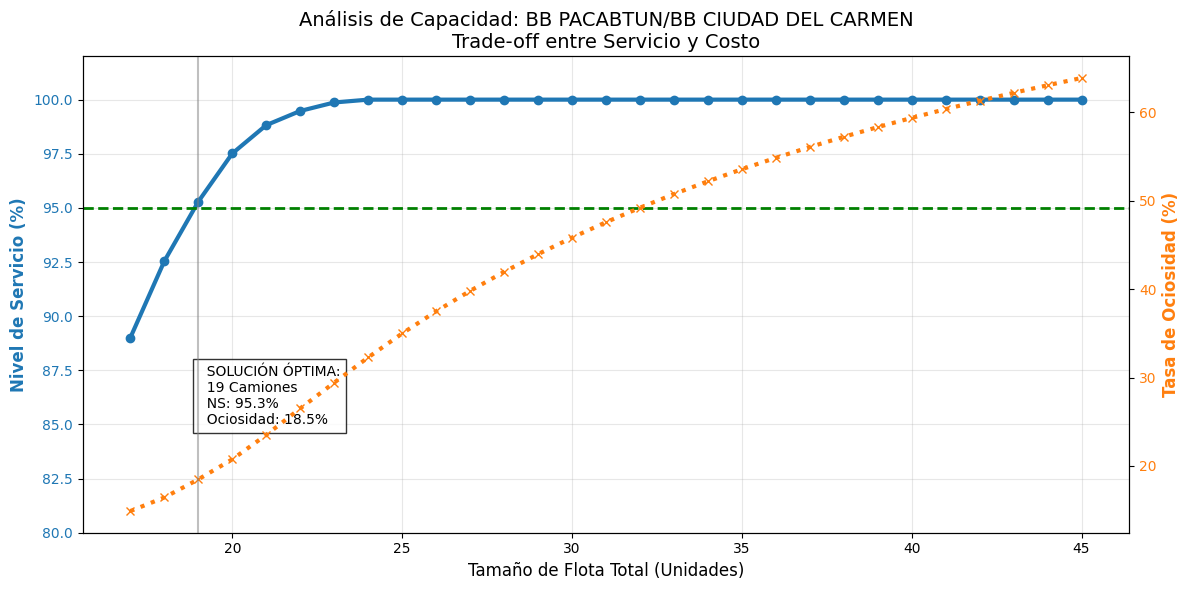

In [ ]:
ruta_objetivo = "BB PACABTUN/BB CIUDAD DEL CARMEN"

# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# CARGA Y LIMPIEZA DE DATOS


listado_viajes = pd.read_excel("/content/Reporte Listado Viajes Ene-Oct_25.xlsx")

listado_viajes['Fecha Vencimiento'] = pd.to_datetime(listado_viajes['Fecha Vencimiento'], errors='coerce')
listado_viajes['Fecha Salida'] = pd.to_datetime(listado_viajes['Fecha Salida'], errors='coerce')
listado_viajes['Fecha Llegada'] = pd.to_datetime(listado_viajes['Fecha Llegada'], errors='coerce')

listado_viajes = listado_viajes.drop(columns=['Documentos', 'UUID CP', 'Peso Descarga Kgs'])
listado_viajes = listado_viajes.dropna(subset=['Fecha Salida', 'Estatus de Viaje', 'Nro Ope', 'Operador', 'Tractocamión'])
listado_viajes = listado_viajes.drop_duplicates(keep='first')

mask = (
    (listado_viajes['Fecha Llegada'].dt.year <= 2025) &
    (listado_viajes['Fecha Salida'].dt.year <= 2025) &
    (listado_viajes['Fecha Salida'].dt.year >= 2024)
)

listado_viajes = listado_viajes[mask]

df_ruta = listado_viajes.copy()


# ASIGNACIÓN DE REGIONES


def assign_region(sucursal):
    if sucursal in ["MERIDA/YUC001", "MERIDA CG/YUC007", "QROO/QUI001", "CARDARRAS/TAB005"]:
        return "Sureste"
    elif sucursal in ["CHALCO/CMX001", "MEXICO/EMX003", "QUERETARO/QRO003"]:
        return "Centro"
    elif sucursal == "MONTERREY/NLE002":
        return "Norte"
    else:
        return "Desconocido"

df_ruta["Region"] = df_ruta["Sucursal"].apply(assign_region)

df_ruta = df_ruta[df_ruta["Region"] == "Sureste"]

# Top 20% rutas
conteo_por_ruta = df_ruta['Ruta'].value_counts()
rutas_top_20 = conteo_por_ruta.nlargest(int(0.2 * len(conteo_por_ruta))).index.tolist()


# PREPARACIÓN PARA SIMULACIÓN


META_NIVEL_SERVICIO = get_service_level_function(ruta_objetivo)
resultados_simulacion = []

df_base = listado_viajes.copy()

# BUCLE DE SIMULACIÓN


for ruta_loop in rutas_top_20:

    df_ruta_loop = df_base[df_base['Ruta'] == ruta_loop].copy()

    if len(df_ruta_loop) < 2:
        continue

    df_ruta_loop['Fecha Salida'] = pd.to_datetime(df_ruta_loop['Fecha Salida'])

    demanda_semanal = (
        df_ruta_loop.set_index('Fecha Salida')
        .resample('W')['Viaje']
        .count()
        .fillna(0)
    )

    media_demanda = demanda_semanal.mean()
    max_demanda = demanda_semanal.max()
    sigma = demanda_semanal.std()

    capacidad_base = int(np.ceil(media_demanda))
    rango_buffer = range(0, int(max_demanda) + 5)

    solucion_encontrada = None

    for buffer in rango_buffer:

        capacidad_total = capacidad_base + buffer

        viajes_atendidos = np.minimum(demanda_semanal, capacidad_total)
        unidades_ociosas = np.maximum(0, capacidad_total - demanda_semanal)

        total_demandado = demanda_semanal.sum()
        total_atendido = viajes_atendidos.sum()

        ns_actual = (total_atendido / total_demandado * 100) if total_demandado > 0 else 0

        if ns_actual >= META_NIVEL_SERVICIO:
            capacidad_disponible_total = capacidad_total * len(demanda_semanal)
            tasa_ociosidad = (unidades_ociosas.sum() / capacidad_disponible_total * 100)

            solucion_encontrada = {
                'Ruta': ruta_loop,
                'Promedio_Semanal': media_demanda,
                'Pico_Maximo': max_demanda,
                'Sigma': sigma,
                'Flota_Base': capacidad_base,
                'Buffer_Optimo': buffer,
                'Flota_Total_Recomendada': capacidad_total,
                'Nivel_Servicio_Logrado': ns_actual,
                'Tasa_Ociosidad': tasa_ociosidad
            }
            break

    if solucion_encontrada:
        resultados_simulacion.append(solucion_encontrada)


# CONSOLIDACIÓN DE RESULTADOS


df_simulacion_final = pd.DataFrame(resultados_simulacion)
df_simulacion_final = df_simulacion_final.sort_values(by='Flota_Total_Recomendada', ascending=False)

display_cols = ['Ruta', 'Promedio_Semanal', 'Sigma',
                'Flota_Total_Recomendada', 'Buffer_Optimo', 'Tasa_Ociosidad']

print(df_simulacion_final[display_cols].head(10).to_string(index=False))


# SELECCIÓN DE LA RUTA A GRAFICAR

datos = df_simulacion_final.loc[df_simulacion_final['Ruta'] == ruta_objetivo]

if datos.empty:
    raise ValueError(f"La ruta '{ruta_objetivo}' no aparece en df_simulacion_final.")

datos = datos.squeeze()
ruta_a_graficar = datos['Ruta']



# RE-SIMULACIÓN PARA GRÁFICO


df_grafico = df_base[df_base['Ruta'] == ruta_a_graficar].copy()
df_grafico['Fecha Salida'] = pd.to_datetime(df_grafico['Fecha Salida'])

demanda_semanal = df_grafico.set_index('Fecha Salida').resample('W')['Viaje'].count().fillna(0)

media = demanda_semanal.mean()
maximo = demanda_semanal.max()
capacidad_base = int(np.ceil(media))
rango_buffer = range(0, int(maximo) + 5)

resultados_curva = []

for buffer in rango_buffer:
    capacidad_total = capacidad_base + buffer
    viajes_atendidos = np.minimum(demanda_semanal, capacidad_total)
    unidades_ociosas = np.maximum(0, capacidad_total - demanda_semanal)

    total_demandado = demanda_semanal.sum()
    total_atendido = viajes_atendidos.sum()

    ns = (total_atendido / total_demandado * 100)
    cap_disp = capacidad_total * len(demanda_semanal)
    tasa_ocio = (unidades_ociosas.sum() / cap_disp * 100)

    resultados_curva.append({
        'Flota_Total': capacidad_total,
        'Nivel_Servicio': ns,
        'Tasa_Ociosidad': tasa_ocio
    })

df_curva = pd.DataFrame(resultados_curva)



# GRÁFICO FINAL


fig, ax1 = plt.subplots(figsize=(12, 6))

# Nivel de Servicio
ax1.set_xlabel('Tamaño de Flota Total (Unidades)', fontsize=12)
ax1.set_ylabel('Nivel de Servicio (%)', color='tab:blue', fontsize=12, fontweight='bold')
ax1.plot(df_curva['Flota_Total'], df_curva['Nivel_Servicio'], color='tab:blue', linewidth=3, marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(80, 102)
ax1.grid(True, alpha=0.3)

# Línea de meta
ax1.axhline(META_NIVEL_SERVICIO, color='green', linestyle='--', linewidth=2)

# Ociosidad
ax2 = ax1.twinx()
ax2.set_ylabel('Tasa de Ociosidad (%)', color='tab:orange', fontsize=12, fontweight='bold')
ax2.plot(df_curva['Flota_Total'], df_curva['Tasa_Ociosidad'], color='tab:orange', linestyle=':', linewidth=3, marker='x')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Punto óptimo
flota_optima = datos['Flota_Total_Recomendada']
ns_optimo = datos['Nivel_Servicio_Logrado']
ocio_optimo = datos['Tasa_Ociosidad']

plt.axvline(flota_optima, color='gray', alpha=0.5)

texto_info = (
    f"  SOLUCIÓN ÓPTIMA:\n"
    f"  {flota_optima:.0f} Camiones\n"
    f"  NS: {ns_optimo:.1f}%\n"
    f"  Ociosidad: {ocio_optimo:.1f}%"
)

ax1.text(flota_optima, 85, texto_info,
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.title(f'Análisis de Capacidad: {ruta_a_graficar}\nTrade-off entre Servicio y Costo', fontsize=14)
fig.tight_layout()
plt.show()

#Tasa de ociosidad: KPI 1

In [ ]:
#OBTENER LA TASA DE OCIOSIDAD DE LA RUTA
ruta_objetivo = "BB PACABTUN/BB CIUDAD DEL CARMEN"
ociosidad = df_simulacion_final.loc[df_simulacion_final['Ruta'] == ruta_objetivo, 'Tasa_Ociosidad'].iloc[0]

#GRAFICA 2:

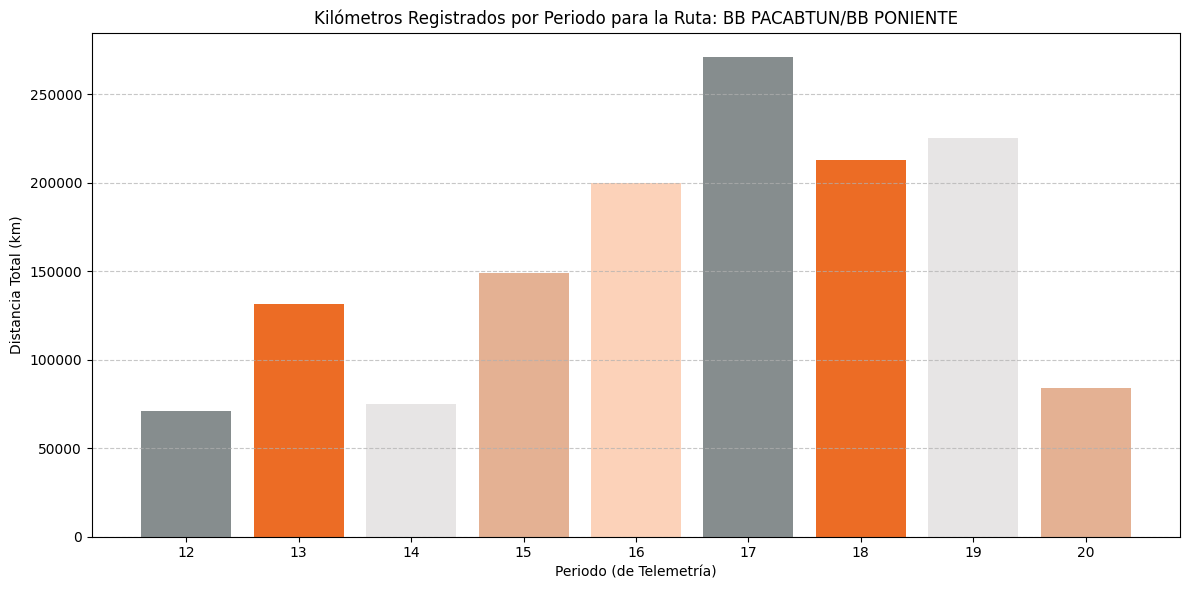

Distancia total registrada por periodo para la ruta 'BB PACABTUN/BB PONIENTE':


,Periodo,Distancia
0,12,70903.600220
1,13,131684.718872
2,14,75052.553711
3,15,148767.008301
4,16,200098.790039
5,17,271147.154602
6,18,213091.191650
7,19,225358.579773
8,20,84014.090820


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Data ---
# Assuming 'Telemetría.xlsx' and 'BEPENSA.xlsx' are in the /content/ directory
telemetria= pd.read_excel("/content/Telemetría.xlsx", sheet_name = "Report")
listado_viajes = pd.read_excel('/content/BEPENSA.xlsx', sheet_name='Reporte Listado Viajes Ene-Oc')

# --- Preprocessing for listado_viajes ---
listado_viajes['Fecha Vencimiento'] = pd.to_datetime(listado_viajes['Fecha Vencimiento'], errors='coerce')
listado_viajes['Fecha Salida'] = pd.to_datetime(listado_viajes['Fecha Salida'], errors='coerce')
listado_viajes['Fecha Llegada'] = pd.to_datetime(listado_viajes['Fecha Llegada'], errors='coerce')
# Removed: listado_viajes = listado_viajes.drop(columns=['Documentos', 'UUID CP']) # These columns caused KeyError
listado_viajes = listado_viajes.dropna(subset=['Fecha Salida'])
listado_viajes = listado_viajes.dropna(subset=['Nro Ope', 'Operador', 'Tractocamión'])
listado_viajes['Factura'] = listado_viajes['Factura'].fillna('SIN FACTURA')
listado_viajes['Remolque 1'] = listado_viajes['Remolque 1'].fillna('SIN REMOLQUE')
listado_viajes['Remolque 2'] = listado_viajes['Remolque 2'].fillna('NO APLICA')
listado_viajes['Dolly'] = listado_viajes['Dolly'].fillna('NO APLICA')
# Removed: listado_viajes = listado_viajes.drop(columns=['Peso Descarga Kgs']) # This column also caused KeyError
listado_viajes['Liquidación'] = listado_viajes['Liquidación'].fillna('PENDIENTE')
# Removed: listado_viajes = listado_viajes.drop(columns=['Diferencia']) # This column also caused KeyError
listado_viajes = listado_viajes.dropna(subset=['Estatus de Viaje'])
listado_viajes = listado_viajes.drop_duplicates(keep='first')
listado_viajes['Peso Kgs'] = pd.to_numeric(listado_viajes['Peso Kgs'])
listado_viajes['diferencia'] = listado_viajes['Fecha Llegada'] - listado_viajes['Fecha Salida']
mask = (listado_viajes['Fecha Llegada'].dt.year <= 2025) & (listado_viajes['Fecha Salida'].dt.year <= 2025) & (listado_viajes['Fecha Salida'].dt.year >= 2024) & (listado_viajes['diferencia'] != "0 days")
listado_viajes = listado_viajes[mask]
df = listado_viajes.copy()

# --- Preprocessing for telemetria (and creating km) ---
telemetria = telemetria.drop_duplicates()
km = telemetria.groupby(['Nombre', 'Periodo'])['Distancia'].sum().reset_index()

# Prepare telemetria for period lookup
telemetria_periods_info = telemetria[['Periodo', 'Fecha de inicio del periodo', 'Fecha de fin del periodo']].drop_duplicates().sort_values('Fecha de inicio del periodo')

# Create a function to find the Periodo for a given date
def find_period_for_date(date, periods_info):
    # Check if the date is NaT (Not a Time) before comparison
    if pd.isna(date):
        return None
    matching_periods = periods_info[
        (periods_info['Fecha de inicio del periodo'] <= date) &
        (periods_info['Fecha de fin del periodo'] >= date)
    ]
    if not matching_periods.empty:
        return matching_periods['Periodo'].iloc[0]
    return None

# Specify the route
route_to_analyze = "BB PACABTUN/BB PONIENTE"

# Filter listado_viajes for the specific route
route_trips = df[df['Ruta'] == route_to_analyze].copy()

# Add a 'Matched_Periodo' column to route_trips by mapping 'Fecha Salida'
route_trips['Matched_Periodo'] = route_trips['Fecha Salida'].apply(lambda x: find_period_for_date(x, telemetria_periods_info))

# Drop rows where no period was matched (e.g., if dates fall outside telemetria's period range)
route_trips.dropna(subset=['Matched_Periodo'], inplace=True)

# Ensure 'Matched_Periodo' is int for merging with 'km' DataFrame
route_trips['Matched_Periodo'] = route_trips['Matched_Periodo'].astype(int)

# Select relevant columns for merging and rename for consistency with 'km'
# We need unique combinations of truck and matched period to merge with 'km'
route_trips_for_merge = route_trips[['Tractocamión', 'Matched_Periodo']].drop_duplicates().rename(columns={'Tractocamión': 'Nombre', 'Matched_Periodo': 'Periodo'})

# Merge with the 'km' DataFrame to get the total distances for these truck-period combinations
# 'km' DataFrame has 'Nombre', 'Periodo', 'Distancia'
merged_distances = pd.merge(route_trips_for_merge, km, on=['Nombre', 'Periodo'], how='left')

# Drop any rows where 'Distancia' couldn't be found (e.g., if km has no entry for a specific truck-period combination)
merged_distances.dropna(subset=['Distancia'], inplace=True)

# Group by Periodo and sum the distances
km_by_period_for_route = merged_distances.groupby('Periodo')['Distancia'].sum().reset_index()

# Sort by Periodo for a clean time series plot
km_by_period_for_route.sort_values('Periodo', inplace=True)

# Define the new monochromatic palette
new_monochromatic_palette = ["#868d8e", "#ec6c25", "#e7e5e5", "#e4b193", "#fcd2b9"]

# Create the plot
plt.figure(figsize=(12, 6))
colors = [new_monochromatic_palette[i % len(new_monochromatic_palette)] for i in range(len(km_by_period_for_route))]
plt.bar(km_by_period_for_route['Periodo'], km_by_period_for_route['Distancia'], color=colors)
plt.xlabel('Periodo (de Telemetría)')
plt.ylabel('Distancia Total (km)')
plt.title(f'Kilómetros Registrados por Periodo para la Ruta: {route_to_analyze}')
plt.xticks(km_by_period_for_route['Periodo'].unique()) # Ensure all period numbers are shown as ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print the data as well
print(f"Distancia total registrada por periodo para la ruta '{route_to_analyze}':")
display(km_by_period_for_route)



---



# Grafico 3

In [ ]:
import pandas as pd

# Reload listado_viajes and perform preprocessing
listado_viajes = pd.read_excel("/content/BEPENSA.xlsx", sheet_name= "Reporte Listado Viajes Ene-Oc")

listado_viajes['Fecha Vencimiento'] = pd.to_datetime(listado_viajes['Fecha Vencimiento'], errors='coerce')
listado_viajes['Fecha Salida'] = pd.to_datetime(listado_viajes['Fecha Salida'], errors='coerce')
listado_viajes['Fecha Llegada'] = pd.to_datetime(listado_viajes['Fecha Llegada'], errors='coerce')
listado_viajes = listado_viajes.drop(columns=['Documentos', 'UUID CP'])
listado_viajes = listado_viajes.dropna(subset=['Fecha Salida'])
listado_viajes = listado_viajes.dropna(subset=['Nro Ope', 'Operador', 'Tractocamión'])
listado_viajes['Factura'] = listado_viajes['Factura'].fillna('SIN FACTURA')
listado_viajes['Remolque 1'] = listado_viajes['Remolque 1'].fillna('SIN REMOLQUE')
listado_viajes['Remolque 2'] = listado_viajes['Remolque 2'].fillna('NO APLICA')
listado_viajes['Dolly'] = listado_viajes['Dolly'].fillna('NO APLICA')
listado_viajes = listado_viajes.drop(columns=['Peso Descarga Kgs'])
listado_viajes['Liquidación'] = listado_viajes['Liquidación'].fillna('PENDIENTE')
listado_viajes = listado_viajes.drop(columns=['Diferencia'])
listado_viajes = listado_viajes.dropna(subset=['Estatus de Viaje'])
listado_viajes = listado_viajes.drop_duplicates(keep='first')
listado_viajes['Peso Kgs'] = pd.to_numeric(listado_viajes['Peso Kgs'])
listado_viajes['diferencia'] = listado_viajes['Fecha Llegada'] - listado_viajes['Fecha Salida']
mask = (listado_viajes['Fecha Llegada'].dt.year <= 2025) & (listado_viajes['Fecha Salida'].dt.year <= 2025) & (listado_viajes['Fecha Salida'].dt.year >= 2024) & (listado_viajes['diferencia'] != "0 days")
listado_viajes = listado_viajes[mask]

df_total = listado_viajes.copy()
df_total['Fecha Salida'] = pd.to_datetime(df_total['Fecha Salida'])

def assign_region(sucursal):
    if sucursal in ["MERIDA/YUC001", "MERIDA CG/YUC007", "QROO/QUI001", "CARDARRAS/TAB005"]:
        return "Sureste"
    elif sucursal in ["CHALCO/CMX001", "MEXICO/EMX003", "QUERETARO/QRO003"]:
        return "Centro"
    elif sucursal == "MONTERREY/NLE002":
        return "Norte"
    else:
        return "Desconocido"

df_total["Region"] = df_total["Sucursal"].apply(assign_region)

print("df_total created with new 'Region' column:")
display(df_total.head())

df_total created with new 'Region' column:


,Numero,Nombre Cliente,Folio,Ruta,Viaje,Viaje Docto,Sucursal,No. Viaje Cte,Fecha...9,Moneda,...,Dolly,Remolque 2,Nro Ope,Operador,Fecha Salida,Fecha Llegada,Peso Kgs,Estatus de Viaje,diferencia,Region
8,1322,NUEVA WAL MART DE MEXICO,532,PENSION SALINAS CRUZ/SAMS SALINA CRUZ,LM/ARR-000002969,CARTA PORTE 000000001934-VVHS,CARDARRAS/TAB005,7074382,2025-02-11,PESOS,...,NO APLICA,NO APLICA,58446.0,SANTIAGO URQUIDI VICTOR ULISES,2025-02-07 17:00:00,2025-09-07 17:19:00,NaN,TERMINADO,212 days 00:19:00,Sureste
9,1322,NUEVA WAL MART DE MEXICO,526,PENSION SALINAS CRUZ/BODEGA AURRERA PUERTO ESC...,LM/ARR-000003227,CARTA PORTE CFDI 000000001128-CPVHS,CARDARRAS/TAB005,7131389,2025-02-18,PESOS,...,NO APLICA,NO APLICA,47258.0,MARTINEZ GOMEZ VICENCIO,2025-02-15 12:00:00,2025-08-15 17:00:00,13544.385,TERMINADO,181 days 05:00:00,Sureste
10,1322,NUEVA WAL MART DE MEXICO,529,PENSION SALINAS CRUZ/BODEGA AURRERA MATIAS ROMERO,LM/ARR-000001600,CARTA PORTE CFDI 000000000560-CPVHS,CARDARRAS/TAB005,6910650,2025-01-15,PESOS,...,NO APLICA,NO APLICA,58804.0,GOMEZ RUSTRIAN ARQUIMIDES,2025-01-11 16:00:00,2025-07-11 18:00:00,9429.462,TERMINADO,181 days 02:00:00,Sureste
11,1322,NUEVA WAL MART DE MEXICO,466,PENSION SALINAS CRUZ/BODEGA AURRERA JUCHITAN,LM/ARR-000002968,CARTA PORTE CFDI 000000001034-CPVHS,CARDARRAS/TAB005,7092423,2025-02-11,PESOS,...,NO APLICA,NO APLICA,58526.0,DE LA ROSA GIL LUIS EMMANUEL,2025-02-10 21:00:00,2025-08-10 22:00:00,14188.757,TERMINADO,181 days 01:00:00,Sureste
12,1322,NUEVA WAL MART DE MEXICO,533,SAMS SALINA CRUZ/PENSION SALINAS CRUZ,LM/ARR-000003224,CARTA PORTE 000000002098-VVHS,CARDARRAS/TAB005,7110853,2025-02-18,PESOS,...,NO APLICA,NO APLICA,47258.0,MARTINEZ GOMEZ VICENCIO,2025-02-12 18:19:00,2025-08-12 19:11:00,NaN,TERMINADO,181 days 00:52:00,Sureste


In [ ]:
import pandas as pd

# Reload listado_viajes and perform preprocessing
listado_viajes = pd.read_excel("/content/BEPENSA.xlsx", sheet_name= "Reporte Listado Viajes Ene-Oc")

listado_viajes['Fecha Vencimiento'] = pd.to_datetime(listado_viajes['Fecha Vencimiento'], errors='coerce')
listado_viajes['Fecha Salida'] = pd.to_datetime(listado_viajes['Fecha Salida'], errors='coerce')
listado_viajes['Fecha Llegada'] = pd.to_datetime(listado_viajes['Fecha Llegada'], errors='coerce')
# listado_viajes = listado_viajes.drop(columns=['Documentos', 'UUID CP']) # Removed as these columns caused KeyError
listado_viajes = listado_viajes.dropna(subset=['Fecha Salida'])
listado_viajes = listado_viajes.dropna(subset=['Nro Ope', 'Operador', 'Tractocamión'])
listado_viajes['Factura'] = listado_viajes['Factura'].fillna('SIN FACTURA')
listado_viajes['Remolque 1'] = listado_viajes['Remolque 1'].fillna('SIN REMOLQUE')
listado_viajes['Remolque 2'] = listado_viajes['Remolque 2'].fillna('NO APLICA')
listado_viajes['Dolly'] = listado_viajes['Dolly'].fillna('NO APLICA')
# listado_viajes = listado_viajes.drop(columns=['Peso Descarga Kgs']) # Removed as this column caused KeyError
listado_viajes['Liquidación'] = listado_viajes['Liquidación'].fillna('PENDIENTE')
# listado_viajes = listado_viajes.drop(columns=['Diferencia']) # Removed as this column caused KeyError
listado_viajes = listado_viajes.dropna(subset=['Estatus de Viaje'])
listado_viajes = listado_viajes.drop_duplicates(keep='first')
listado_viajes['Peso Kgs'] = pd.to_numeric(listado_viajes['Peso Kgs'])
listado_viajes['diferencia'] = listado_viajes['Fecha Llegada'] - listado_viajes['Fecha Salida']
mask = (listado_viajes['Fecha Llegada'].dt.year <= 2025) & (listado_viajes['Fecha Salida'].dt.year <= 2025) & (listado_viajes['Fecha Salida'].dt.year >= 2024) & (listado_viajes['diferencia'] != "0 days")
listado_viajes = listado_viajes[mask]

df_total = listado_viajes.copy()
df_total['Fecha Salida'] = pd.to_datetime(df_total['Fecha Salida'])

def assign_region(sucursal):
    if sucursal in ["MERIDA/YUC001", "MERIDA CG/YUC007", "QROO/QUI001", "CARDARRAS/TAB005"]:
        return "Sureste"
    elif sucursal in ["CHALCO/CMX001", "MEXICO/EMX003", "QUERETARO/QRO003"]:
        return "Centro"
    elif sucursal == "MONTERREY/NLE002":
        return "Norte"
    else:
        return "Desconocido"

df_total["Region"] = df_total["Sucursal"].apply(assign_region)

print("df_total created with new 'Region' column:")
display(df_total.head())

df_total created with new 'Region' column:


,Numero,Nombre Cliente,Folio,Ruta,Viaje,Viaje Docto,Sucursal,No. Viaje Cte,Fecha...9,Moneda,...,Fecha Salida,Fecha Llegada,Peso Kgs,Peso Descarga Kgs,Diferencia,Documentos,UUID CP,Estatus de Viaje,diferencia,Region
8,1322,NUEVA WAL MART DE MEXICO,532,PENSION SALINAS CRUZ/SAMS SALINA CRUZ,LM/ARR-000002969,CARTA PORTE 000000001934-VVHS,CARDARRAS/TAB005,7074382,2025-02-11,PESOS,...,2025-02-07 17:00:00,2025-09-07 17:19:00,NaN,NaN,NaN,NaN,NaN,TERMINADO,212 days 00:19:00,Sureste
9,1322,NUEVA WAL MART DE MEXICO,526,PENSION SALINAS CRUZ/BODEGA AURRERA PUERTO ESC...,LM/ARR-000003227,CARTA PORTE CFDI 000000001128-CPVHS,CARDARRAS/TAB005,7131389,2025-02-18,PESOS,...,2025-02-15 12:00:00,2025-08-15 17:00:00,13544.385,NaN,13544.385,NaN,NaN,TERMINADO,181 days 05:00:00,Sureste
10,1322,NUEVA WAL MART DE MEXICO,529,PENSION SALINAS CRUZ/BODEGA AURRERA MATIAS ROMERO,LM/ARR-000001600,CARTA PORTE CFDI 000000000560-CPVHS,CARDARRAS/TAB005,6910650,2025-01-15,PESOS,...,2025-01-11 16:00:00,2025-07-11 18:00:00,9429.462,NaN,9429.462,NaN,NaN,TERMINADO,181 days 02:00:00,Sureste
11,1322,NUEVA WAL MART DE MEXICO,466,PENSION SALINAS CRUZ/BODEGA AURRERA JUCHITAN,LM/ARR-000002968,CARTA PORTE CFDI 000000001034-CPVHS,CARDARRAS/TAB005,7092423,2025-02-11,PESOS,...,2025-02-10 21:00:00,2025-08-10 22:00:00,14188.757,NaN,14188.757,NaN,NaN,TERMINADO,181 days 01:00:00,Sureste
12,1322,NUEVA WAL MART DE MEXICO,533,SAMS SALINA CRUZ/PENSION SALINAS CRUZ,LM/ARR-000003224,CARTA PORTE 000000002098-VVHS,CARDARRAS/TAB005,7110853,2025-02-18,PESOS,...,2025-02-12 18:19:00,2025-08-12 19:11:00,NaN,NaN,NaN,NaN,NaN,TERMINADO,181 days 00:52:00,Sureste


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Calculate Total_Viajes by Ruta
ruta_volumen = df_total.groupby('Ruta')['Viaje'].count().reset_index(name='Total_Viajes')

# 2. Calculate the number of trips for the largest client per route
ruta_cliente = df_total.groupby(['Ruta', 'Nombre Cliente'])['Viaje'].count().reset_index()
ruta_max_cliente = ruta_cliente.sort_values(['Ruta', 'Viaje'], ascending=[True, False]) \
                               .groupby('Ruta').first().reset_index()

# 3. Merge and calculate percentage dependence
data_cluster = pd.merge(ruta_volumen, ruta_max_cliente[['Ruta', 'Viaje']], on='Ruta')
data_cluster.rename(columns={'Viaje': 'Viajes_Cliente_Top'}, inplace=True)

data_cluster['Porcentaje_Dependencia'] = data_cluster['Viajes_Cliente_Top'] / data_cluster['Total_Viajes']

# Select the variables for clustering
X = data_cluster[['Total_Viajes', 'Porcentaje_Dependencia']]

# Standardize data for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Assign the cluster labels back to the DataFrame
data_cluster['Cluster_Riesgo'] = labels

# Identify routes for each cluster
cluster_0 = data_cluster[data_cluster['Cluster_Riesgo'] == 0]['Ruta'].tolist()
cluster_1 = data_cluster[data_cluster['Cluster_Riesgo'] == 1]['Ruta'].tolist()
cluster_2 = data_cluster[data_cluster['Cluster_Riesgo'] == 2]['Ruta'].tolist()

print("K-Means clustering performed and routes categorized into cluster_0, cluster_1, and cluster_2.")
print(f"Number of routes in Cluster 0: {len(cluster_0)}")
print(f"Number of routes in Cluster 1: {len(cluster_1)}")
print(f"Number of routes in Cluster 2: {len(cluster_2)}")

K-Means clustering performed and routes categorized into cluster_0, cluster_1, and cluster_2.
Number of routes in Cluster 0: 2128
Number of routes in Cluster 1: 10
Number of routes in Cluster 2: 50


In [ ]:
import pandas as pd
import numpy as np

# 1. Financial Constants (from previous analysis)
COSTO_DIARIO_PARADO = 3941.96
COSTO_MOVIMIENTO_VACIO = 9568.58
DIAS_LIMITE_ESPERA = 2 # Break-even point for decision making

# 2. Create the cluster mapping from route name to cluster category
# This maps the actual route name to a human-readable cluster description
mapa_clusters = {}

# Ensure these cluster variables (cluster_0, cluster_1, cluster_2) are defined from previous clustering step
for r in cluster_2: mapa_clusters[r] = "Cluster 2 (CRÍTICO)"
for r in cluster_1: mapa_clusters[r] = "Cluster 1 (MODERADO)"
for r in cluster_0: mapa_clusters[r] = "Cluster 0 (BAJO)"

# 3. Define service level goals for each cluster
METAS_POR_CLUSTER = {
    "Cluster 2 (CRÍTICO)":      98.0, # High importance, high service level
    "Cluster 1 (MODERADO)":     95.0, # Moderate importance, moderate service level
    "Cluster 0 (BAJO)":         90.0, # Lower importance, lower service level
    "Desconocido":              98.0  # Default for routes not in any cluster
}

print("Financial constants, cluster mapping, and service level goals defined.")

Financial constants, cluster mapping, and service level goals defined.


In [ ]:
import pandas as pd
import numpy as np

# Filter df_total for the 'Sureste' region
df_sureste_completo = df_total[df_total['Region'] == 'Sureste'].copy()

# Get all unique routes in the Sureste region
todas_rutas_sureste = df_sureste_completo['Ruta'].unique()

resultados_masivos = []

for ruta in todas_rutas_sureste:

    # A. Identify Cluster and Meta Service Level
    cluster_actual = mapa_clusters.get(ruta, "Desconocido")
    meta_objetivo_actual = METAS_POR_CLUSTER.get(cluster_actual, 98.0) # Default to 98% if cluster is unknown

    # B. Filter data for the current route
    df_ruta = df_sureste_completo[df_sureste_completo['Ruta'] == ruta].copy()

    # Skip routes with insufficient data (e.g., less than 2 data points for demand calculation)
    if len(df_ruta) < 2:
        continue

    # C. Calculate weekly demand
    demanda_semanal = df_ruta.set_index('Fecha Salida').resample('W')['Viaje'].count().fillna(0)

    # Skip if demand data is empty after resampling
    if demanda_semanal.empty or demanda_semanal.sum() == 0:
        continue

    media_demanda = demanda_semanal.mean()
    max_demanda = demanda_semanal.max()
    sigma = demanda_semanal.std()

    # Calculate frequency of travel
    frecuencia_dias = 7 / media_demanda if media_demanda > 0 else np.inf

    # D. Iterative Simulation to find optimal buffer
    capacidad_base = int(np.ceil(media_demanda))
    # Ensure rango_buffer always generates values, even if max_demanda is 0 or negative
    rango_buffer = range(0, max(1, int(max_demanda) + 5))

    buffer_elegido = 0
    flota_final = capacidad_base
    ns_logrado = 0.0

    for buffer in rango_buffer:
        capacidad_total = capacidad_base + buffer

        # Vectorized calculations for service level
        viajes_atendidos = np.minimum(demanda_semanal, capacidad_total)
        total_demandado = demanda_semanal.sum()

        ns = (viajes_atendidos.sum() / total_demandado * 100) if total_demandado > 0 else 0

        if ns >= meta_objetivo_actual:
            buffer_elegido = buffer
            flota_final = capacidad_total
            ns_logrado = ns
            break

    # If no buffer could meet the target, default to the max capacity simulated
    if ns_logrado < meta_objetivo_actual and not demanda_semanal.empty:
        # If loop finishes and meta is not met, take the last simulated capacity
        capacidad_total_last = capacidad_base + rango_buffer[-1] if rango_buffer else capacidad_base
        viajes_atendidos_last = np.minimum(demanda_semanal, capacidad_total_last)
        total_demandado = demanda_semanal.sum()
        ns_logrado = (viajes_atendidos_last.sum() / total_demandado * 100) if total_demandado > 0 else 0
        buffer_elegido = rango_buffer[-1] if rango_buffer else 0
        flota_final = capacidad_total_last

    # E. Financial Evaluation
    costo_buffer = buffer_elegido * COSTO_DIARIO_PARADO * 30

    if frecuencia_dias > DIAS_LIMITE_ESPERA:
        decision = "MOVER EN VACÍO / CONSOLIDAR"
    else:
        decision = "MANTENER FLOTA (Wait)"

    # F. Store results
    resultados_masivos.append({
        'Ruta': ruta,
        'Cluster': cluster_actual,
        'Meta_NS_Exigida': meta_objetivo_actual,
        'NS_Logrado': ns_logrado,
        'Promedio_Semanal': media_demanda,
        'Sigma_Volatilidad': sigma,
        'Frecuencia_Dias': frecuencia_dias,
        'Buffer_Optimo': buffer_elegido,
        'Flota_Total': flota_final,
        'Costo_Mensual_Buffer': costo_buffer,
        'Estrategia_Sugerida': decision
    })

# Consolidate results into a DataFrame
df_simulacion_final = pd.DataFrame(resultados_masivos)

# Sort by Flota_Total in descending order as requested
df_vista_final = df_simulacion_final.sort_values(by='Flota_Total', ascending=False)

print("Simulation for all Sureste routes completed and results stored in df_vista_final.")
# Display the top 20 routes of df_vista_final with the specified columns
display_cols = [
    'Ruta',
    'Cluster',
    'Promedio_Semanal',
    'Buffer_Optimo',
    'Flota_Total',
    'Estrategia_Sugerida',
    'Costo_Mensual_Buffer'
]

print("\n--- TABLA DE DECISIÓN DETALLADA POR RUTA (TOP 20) ---")
pd.options.display.float_format = '{:,.2f}'.format
display(df_vista_final[display_cols].head(20))

Simulation for all Sureste routes completed and results stored in df_vista_final.

--- TABLA DE DECISIÓN DETALLADA POR RUTA (TOP 20) ---


,Ruta,Cluster,Promedio_Semanal,Buffer_Optimo,Flota_Total,Estrategia_Sugerida,Costo_Mensual_Buffer
14,BB PONIENTE/BB PACABTUN,Cluster 2 (CRÍTICO),48.87,9,58,MANTENER FLOTA (Wait),"1,064,329.20"
66,BB PACABTUN/BB PONIENTE,Cluster 2 (CRÍTICO),48.87,9,58,MANTENER FLOTA (Wait),"1,064,329.20"
27,BB PLAYA DEL CARMEN/BB CANCUN PLANTA,Cluster 2 (CRÍTICO),25.96,11,37,MANTENER FLOTA (Wait),"1,300,846.80"
94,BB CANCUN PLANTA/BB PLAYA DEL CARMEN,Cluster 2 (CRÍTICO),25.20,9,35,MANTENER FLOTA (Wait),"1,064,329.20"
36,PENSION SALINAS CRUZ/WM CEDIS VILLAHERMOSA SECOS,Cluster 2 (CRÍTICO),30.93,4,35,MANTENER FLOTA (Wait),"473,035.20"
25,WM CEDIS VILLAHERMOSA SECOS/PENSION SALINAS CRUZ,Cluster 2 (CRÍTICO),32.39,2,35,MANTENER FLOTA (Wait),"236,517.60"
47,BB CANCUN PLANTA/BB PACABTUN,Cluster 2 (CRÍTICO),19.59,10,30,MANTENER FLOTA (Wait),"1,182,588.00"
34,BB PACABTUN/BB CANCUN PLANTA,Cluster 2 (CRÍTICO),21.33,8,30,MANTENER FLOTA (Wait),"946,070.40"
89,BB CAMPECHE OTE/BB PACABTUN,Cluster 2 (CRÍTICO),24.49,3,28,MANTENER FLOTA (Wait),"354,776.40"
54,BB PACABTUN/BB CAMPECHE OTE,Cluster 2 (CRÍTICO),24.42,3,28,MANTENER FLOTA (Wait),"354,776.40"


In [ ]:
import pandas as pd

# Define the columns to display
display_cols = [
    'Ruta',
    'Cluster',
    'Promedio_Semanal',
    'Buffer_Optimo',
    'Flota_Total',
    'Estrategia_Sugerida',
    'Costo_Mensual_Buffer'
]

# Set float display format for better readability
pd.options.display.float_format = '{:,.2f}'.format

# Display the df_vista_final DataFrame with the selected columns
print("\n--- TABLA DE DECISIÓN DETALLADA POR RUTA (FINAL) ---")
display(df_vista_final[display_cols])


--- TABLA DE DECISIÓN DETALLADA POR RUTA (FINAL) ---


,Ruta,Cluster,Promedio_Semanal,Buffer_Optimo,Flota_Total,Estrategia_Sugerida,Costo_Mensual_Buffer
14,BB PONIENTE/BB PACABTUN,Cluster 2 (CRÍTICO),48.87,9,58,MANTENER FLOTA (Wait),"1,064,329.20"
66,BB PACABTUN/BB PONIENTE,Cluster 2 (CRÍTICO),48.87,9,58,MANTENER FLOTA (Wait),"1,064,329.20"
27,BB PLAYA DEL CARMEN/BB CANCUN PLANTA,Cluster 2 (CRÍTICO),25.96,11,37,MANTENER FLOTA (Wait),"1,300,846.80"
94,BB CANCUN PLANTA/BB PLAYA DEL CARMEN,Cluster 2 (CRÍTICO),25.20,9,35,MANTENER FLOTA (Wait),"1,064,329.20"
36,PENSION SALINAS CRUZ/WM CEDIS VILLAHERMOSA SECOS,Cluster 2 (CRÍTICO),30.93,4,35,MANTENER FLOTA (Wait),"473,035.20"
...,...,...,...,...,...,...,...
844,WM LA CRUZ PLAYA DEL CARMEN/WM PLAYA DEL CARME...,Cluster 0 (BAJO),0.11,0,1,MOVER EN VACÍO / CONSOLIDAR,0.00
843,BODEGA AURRERA BUENOS AIRES TAPACHULA/AURRERA ...,Cluster 0 (BAJO),1.00,0,1,MOVER EN VACÍO / CONSOLIDAR,0.00
863,BODEGA CHETUMAL NORTE/BODEGA AURRERA CHETUMAL ...,Cluster 0 (BAJO),0.17,0,1,MOVER EN VACÍO / CONSOLIDAR,0.00
862,SUPERCENTER MERIDA NORTE/SUPER CENTER POLIGONO,Cluster 0 (BAJO),0.21,0,1,MOVER EN VACÍO / CONSOLIDAR,0.00


In [ ]:
import altair as alt


In [ ]:
chart = alt.Chart(df_vista_final.head(20)).mark_bar().encode(
    x=alt.X('Ruta', sort=alt.EncodingSortField(field="Costo_Mensual_Buffer", op="sum", order="descending"), axis=None),
    y=alt.Y('Costo_Mensual_Buffer', title='Costo Mensual de Buffer (MXN)', axis=alt.Axis(format='$,.2f')),
    color=alt.Color('Estrategia_Sugerida', title='Estrategia Sugerida'),
    tooltip=[
        alt.Tooltip('Ruta', title='Ruta'),
        alt.Tooltip('Costo_Mensual_Buffer', title='Costo Mensual Buffer', format='$,.2f'),
        alt.Tooltip('Estrategia_Sugerida', title='Estrategia Sugerida')
    ]
).properties(
    title='Costo Mensual de Buffer por Ruta y Estrategia Sugerida (Top 20)'
).interactive()

chart

alt.Chart(...)